Uno de nuestros clientes opera en el mercado de inmuebles. Está especialmente
interesado en Madrid, donde posee una cantidad importante de viviendas
publicadas en la plataforma AirBnB y nos pide que le asesoremos respondiendo a
la siguiente pregunta:

<div style="text-align:center; color:#FF5A5F; font-size:larger; font-weight:bold; border: 2px #FF5A5F; padding: 10px;">
    ¿Qué puedo hacer para optimizar el precio de mis viviendas?
</div>

1. Elaborar un contexto del problema
2. Definir el problema que queremos resolver
3. Definir y desarrollar el roadmap del análisis
4. Recopilar los principales insights para montar el storytelling final:
    - contexto
    - problema
    - insights

CONSIDERACIONES:  

Al analizar neighbourhood_group (distritos de Madrid), se quita Vicálvaro, ya que no hay suficientes entradas para analizar.

In [2]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

df_conditions = pd.read_parquet('/Users/sebasastre/Desktop/Nuclio Bootcamp Docs/Statistical thinking/Recursos  Comunicación de resultados con datos-20240417/projecto_final/airbnb_madrid_conditions.parquet')
df_host = pd.read_parquet('/Users/sebasastre/Desktop/Nuclio Bootcamp Docs/Statistical thinking/Recursos  Comunicación de resultados con datos-20240417/projecto_final/airbnb_madrid_host.parquet')
df_location = pd.read_parquet('/Users/sebasastre/Desktop/Nuclio Bootcamp Docs/Statistical thinking/Recursos  Comunicación de resultados con datos-20240417/projecto_final/airbnb_madrid_location.parquet')
df_property = pd.read_parquet('/Users/sebasastre/Desktop/Nuclio Bootcamp Docs/Statistical thinking/Recursos  Comunicación de resultados con datos-20240417/projecto_final/airbnb_madrid_property.parquet')
df_reviews = pd.read_parquet('/Users/sebasastre/Desktop/Nuclio Bootcamp Docs/Statistical thinking/Recursos  Comunicación de resultados con datos-20240417/projecto_final/airbnb_madrid_reviews.parquet')

# Unir sucesivamente los DataFrames utilizando la columna común 'id'
df_completo = pd.merge(df_conditions, df_host, on='id', how='inner')
df_completo = pd.merge(df_completo , df_location, on='id', how='inner')
df_completo = pd.merge(df_completo , df_property, on='id', how='inner')
df_completo = pd.merge(df_completo , df_reviews, on='id', how='inner')
# Eliminar todas las entradas del neighbourhood_group 'Vicálvaro'
df_completo = df_completo[df_completo['neighbourhood_group'] != 'Vicálvaro']
# Eliminar las filas donde room_type sea igual a "hotel_room"
df_completo = df_completo[df_completo['room_type'] != 'hotel_room']

# Ahora df_completo  contiene el resultado de unir todos los DataFrames en función de la columna 'id'
df_completo 

id  price  minimum_nights  maximum_nights  \
0          0   70.0               1             365   
1          1   17.0               4              40   
2          2   50.0              15             730   
3          3   80.0               5             730   
4          4  115.0               3              10   
...      ...    ...             ...             ...   
21015  21360   30.0               1               4   
21016  21361   35.0               3            1125   
21017  21363   59.0              25            1125   
21018  21364   49.0               1              30   
21019  21365   22.0               2            1125   

               cancellation_policy  require_guest_profile_picture  \
0                         flexible                              0   
1      strict_14_with_grace_period                              0   
2                         moderate                              0   
3                         moderate                              0   
4                         moderate                              0   
...                            ...                            ...   
21015                     flexible                              0   
21016                     flexible                              0   
21017                     flexible                              0   
21018                     flexible                              0   
21019  strict_14_with_grace_period                              0   

       require_guest_phone_verification  host_response_time  \
0                                     0      within_an_hour   
1                                     0                None   
2                                     0      within_an_hour   
3                                     0  within_a_few_hours   
4                                     0      within_an_hour   
...                                 ...                 ...   
21015                                 0                None   
21016                                 0      within_an_hour   
21017                                 0                None   
21018                                 0      within_an_hour   
21019                                 0                None   

       host_response_rate  host_is_superhost  ...  review_scores_checkin  \
0                   100.0                  1  ...                   10.0   
1                     NaN                  0  ...                   10.0   
2                   100.0                  0  ...                    NaN   
3                   100.0                  0  ...                   10.0   
4                   100.0                  1  ...                   10.0   
...                   ...                ...  ...                    ...   
21015                 NaN                  0  ...                    NaN   
21016               100.0                  0  ...                    NaN   
21017                 NaN                  0  ...                    NaN   
21018               100.0                  0  ...                    NaN   
21019                 NaN                  0  ...                    NaN   

       review_scores_communication  review_scores_location  \
0                             10.0                     9.0   
1                             10.0                     8.0   
2                              NaN                     NaN   
3                             10.0                    10.0   
4                             10.0                    10.0   
...                            ...                     ...   
21015                          NaN                     NaN   
21016                          NaN                     NaN   
21017                          NaN                     NaN   
21018                          NaN                     NaN   
21019                          NaN                     NaN   

       review_scores_value  reviews_per_month  days_since_last_review  \
0                     10.0      

-----

<font size="10" color="#FF5A5F">CONTEXTO</font>

Se analizarán los listados para viviendas, excluyendo habitaciones de hoteles:  

shared_room (habitación compartida) hasta 70 euros  
private_room (habitación privada) hasta 120 euros  
entire_home_apt (piso/casa entera) hasta 300 euros  

Se considerarán estos tipos de alquileres para analizar las variables que puedan influir en los precios dentro de estos rangos.  

En primer lugar, se llevará a cabo un análisis de los precios de mercado para determinar si los alquileres listados por el cliente se ajustan a ellos.  
Posteriormente, se analizarán las variables que podrían influir en los precios más altos dentro de los rangos mencionados.  

--------

In [3]:
# PORCENTAJE DENTRO DEL TOTAL DE LISTADOS POR CANTIDAD DE GENTE POR ALQUILER

# Conteo de listados que acomodan a diferentes cantidades de personas hasta 8 personas
total_accommodates = df_completo[df_completo['accommodates'] <= 8]['accommodates'].value_counts()

# Calcular el porcentaje
percentage_accommodates = (total_accommodates / len(df_completo[df_completo['accommodates'] <= 8])) * 100

# Ordenar los resultados de menor a mayor número de personas
percentage_accommodates = percentage_accommodates.sort_index()

print("Porcentaje dentro del total de listados que acomodan a:\n")
for i, count in enumerate(percentage_accommodates.index):
    print(f"{count} persona(s): {percentage_accommodates[count]:.2f}%")


Porcentaje dentro del total de listados que acomodan a:

1 persona(s): 13.99%
2 persona(s): 34.11%
3 persona(s): 9.38%
4 persona(s): 24.48%
5 persona(s): 5.19%
6 persona(s): 9.22%
7 persona(s): 1.33%
8 persona(s): 2.29%


-------

1. <font size="10" color="#FF5A5F">DISTRIBUCION DE LOS PRECIOS </font>


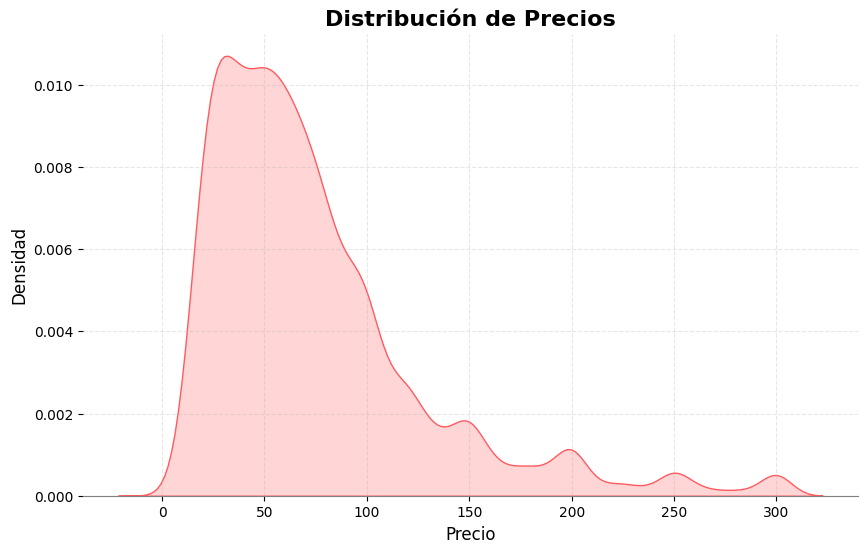

In [4]:
# GRÁFICO DE DENSIDAD DE DISTRIBUCIÓN DE PRECIOS HASTA 300 EUROS

# Filtrar los datos para limitar el precio de 1 a 300
filtered_data = df_completo[df_completo['price'] <= 300]

# Configurar tamaño del plot
plt.figure(figsize=(10, 6))

# Gráfico de densidad de distribución de precios
sns.kdeplot(filtered_data['price'], color='#FF5A5F', fill=True)

# Añadir título al plot y a los ejes
plt.title("Distribución de Precios", fontsize=16, fontweight="bold")
plt.xlabel("Precio", fontsize=12)
plt.ylabel("Densidad", fontsize=12)

# Personalizar el grid de fondo
plt.grid(alpha=0.3, linestyle="--")

# Personalizar el marco del plot
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_color("gray")

# Mostrar plot
plt.show()


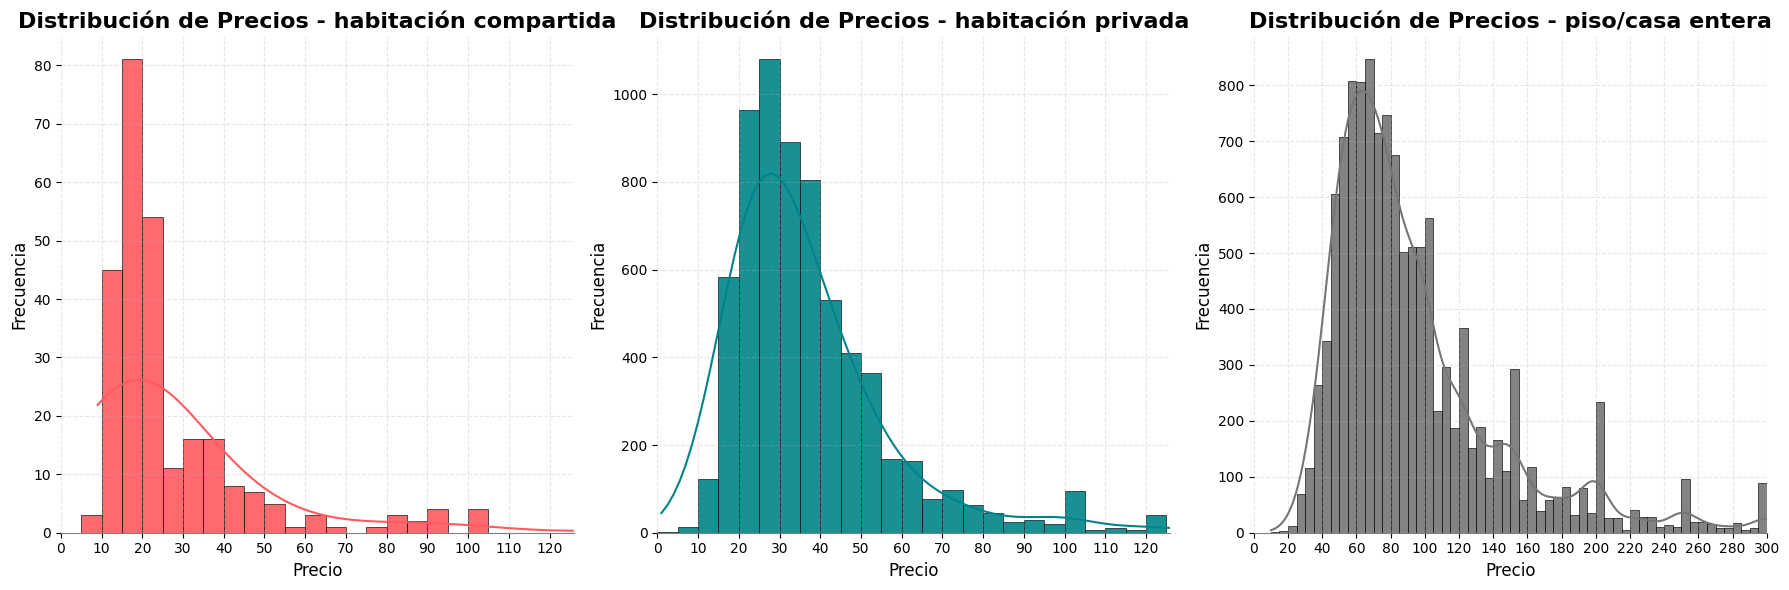

In [5]:
# HISTOGRAMA DE DISTRIBUCIÓN DE PRECIOS SEGÚN TIPO DE HABITACIÓN/ALQUILER

# Filtrar los datos para limitar el precio de 1 a 300
filtered_data_private_room = df_completo[(df_completo['price'] <= 300) & (df_completo['room_type'] == 'private_room')]
filtered_data_shared_room = df_completo[(df_completo['price'] <= 300) & (df_completo['room_type'] == 'shared_room')]
filtered_data_entire_home_apt = df_completo[(df_completo['price'] <= 300) & (df_completo['room_type'] == 'entire_home_apt')]

# Configurar tamaño del plot
plt.figure(figsize=(18, 6))

# Histograma de distribución de precios - shared_room
plt.subplot(1, 3, 1)
sns.histplot(filtered_data_shared_room['price'], bins=range(0, 126, 5), color='#FF5A5F', alpha=0.9, kde=True)
plt.title("Distribución de Precios - habitación compartida", fontsize=16, fontweight="bold")
plt.xlabel("Precio", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xlim(1, 126)  # Ajustar el rango del eje x
plt.xticks(range(0, 126, 10))
plt.grid(alpha=0.3, linestyle="--")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_color("gray")

# Histograma de distribución de precios - private_room
plt.subplot(1, 3, 2)
sns.histplot(filtered_data_private_room['price'], bins=range(0, 126, 5), color='#008489', alpha=0.9, kde=True)
plt.title("Distribución de Precios - habitación privada", fontsize=16, fontweight="bold")
plt.xlabel("Precio", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xlim(1, 126)  # Ajustar el rango del eje x
plt.xticks(range(0, 126, 10))
plt.grid(alpha=0.3, linestyle="--")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_color("gray")

# Histograma de distribución de precios - entire_home_apt
plt.subplot(1, 3, 3)
sns.histplot(filtered_data_entire_home_apt['price'], bins=range(0, 301, 5), color='#767676', alpha=0.9, kde=True)
plt.title("Distribución de Precios - piso/casa entera", fontsize=16, fontweight="bold")
plt.xlabel("Precio", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xlim(1, 300)  # Ajustar el rango del eje x
plt.xticks(range(0, 301, 20))
plt.grid(alpha=0.3, linestyle="--")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_color("gray")

# Ajustar el diseño
plt.tight_layout()

# Mostrar plot
plt.show()


--------

2. <font size="10" color="#FF5A5F">PRECIOS POR DISTRITO SEGÚN EL TIPO DE HOSPEDAJE </font>

In [6]:
# PRECIOS POR DISTRITO, TIPO DE HABITACIÓN PARA 1-2 PERSONAS

# Definir los filtros por tipo de habitación, precio y acomodates
conditions = (
    ((df_completo['room_type'] == 'shared_room') & (df_completo['price'] <= 70) & (df_completo['accommodates'].isin([1, 2]))) |
    ((df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120) & (df_completo['accommodates'].isin([1, 2]))) |
    ((df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300) & (df_completo['accommodates'].isin([1, 2])))
)

# Aplicar los filtros
df_filtered = df_completo[conditions]

# Generar los boxplots con Plotly
fig_shared_room = px.box(df_filtered[df_filtered['room_type'] == 'shared_room'], 
                         x='neighbourhood_group', y='price', 
                         title='Precios de habitación compartida hasta 70 € (1-2 personas)', 
                         category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                         color_discrete_sequence=['#008489'])
fig_shared_room.update_xaxes(title='Distrito')

fig_private_room = px.box(df_filtered[df_filtered['room_type'] == 'private_room'], 
                          x='neighbourhood_group', y='price', 
                          title='Precios de habitación privada hasta 120 € (1-2 personas)', 
                          category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                          color_discrete_sequence=['#FF5A5F'])
fig_private_room.update_xaxes(title='Distrito')

fig_entire_home_apt = px.box(df_filtered[df_filtered['room_type'] == 'entire_home_apt'], 
                              x='neighbourhood_group', y='price', 
                              title='Precios de piso/casa entera hasta 300 € (1-2 personas)', 
                              category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                              color_discrete_sequence=['#767676'])
fig_entire_home_apt.update_xaxes(title='Distrito')

# Mostrar los boxplots
fig_shared_room.show()
fig_private_room.show()
fig_entire_home_apt.show()


In [7]:
# PRECIOS POR DISTRITO, TIPO DE HABITACIÓN PARA 3-4 PERSONAS

# Definir los filtros por tipo de habitación, precio y acomodates
conditions = (
    ((df_completo['room_type'] == 'shared_room') & (df_completo['price'] <= 70) & (df_completo['accommodates'].isin([3, 4]))) |
    ((df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120) & (df_completo['accommodates'].isin([3, 4]))) |
    ((df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300) & (df_completo['accommodates'].isin([3, 4])))
)

# Aplicar los filtros
df_filtered = df_completo[conditions]

# Generar los boxplots con Plotly
fig_shared_room = px.box(df_filtered[df_filtered['room_type'] == 'shared_room'], 
                         x='neighbourhood_group', y='price', 
                         title='Precios de habitación compartida hasta 70 € (3-4 personas)', 
                         category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                         color_discrete_sequence=['#008489'])
fig_shared_room.update_xaxes(title='Distrito')

fig_private_room = px.box(df_filtered[df_filtered['room_type'] == 'private_room'], 
                          x='neighbourhood_group', y='price', 
                          title='Precios de habitación privada hasta 120 € (3-4 personas)', 
                          category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                          color_discrete_sequence=['#FF5A5F'])
fig_private_room.update_xaxes(title='Distrito')

fig_entire_home_apt = px.box(df_filtered[df_filtered['room_type'] == 'entire_home_apt'], 
                              x='neighbourhood_group', y='price', 
                              title='Precios de piso/casa entera hasta 300 € (3-4 personas)', 
                              category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                              color_discrete_sequence=['#767676'])
fig_entire_home_apt.update_xaxes(title='Distrito')

# Mostrar los boxplots
fig_shared_room.show()
fig_private_room.show()
fig_entire_home_apt.show()


In [8]:
# PRECIOS POR DISTRITO, TIPO DE HABITACIÓN PARA 5-6 PERSONAS

# Definir los filtros por tipo de habitación, precio y acomodates
conditions = (
    ((df_completo['room_type'] == 'shared_room') & (df_completo['price'] <= 70) & (df_completo['accommodates'].isin([5, 6]))) |
    ((df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120) & (df_completo['accommodates'].isin([5, 6]))) |
    ((df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300) & (df_completo['accommodates'].isin([5, 6])))
)

# Aplicar los filtros
df_filtered = df_completo[conditions]

# Generar los boxplots con Plotly
fig_shared_room = px.box(df_filtered[df_filtered['room_type'] == 'shared_room'], 
                         x='neighbourhood_group', y='price', 
                         title='Precios de habitación compartida hasta 70 € (5-6 personas)', 
                         category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                         color_discrete_sequence=['#008489'])
fig_shared_room.update_xaxes(title='Distrito')

fig_private_room = px.box(df_filtered[df_filtered['room_type'] == 'private_room'], 
                          x='neighbourhood_group', y='price', 
                          title='Precios de habitación privada hasta 120 € (5-6 personas)', 
                          category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                          color_discrete_sequence=['#FF5A5F'])
fig_private_room.update_xaxes(title='Distrito')

fig_entire_home_apt = px.box(df_filtered[df_filtered['room_type'] == 'entire_home_apt'], 
                              x='neighbourhood_group', y='price', 
                              title='Precios de piso/casa entera hasta 300 € (5-6 personas)', 
                              category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                              color_discrete_sequence=['#767676'])
fig_entire_home_apt.update_xaxes(title='Distrito')

# Mostrar los boxplots
fig_shared_room.show()
fig_private_room.show()
fig_entire_home_apt.show()

In [9]:
# PRECIOS POR DISTRITO, TIPO DE HABITACIÓN PARA 7 PERSONAS O MÁS

# Definir los filtros por tipo de habitación, precio y acomodates
conditions = (
    ((df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120) & (df_completo['accommodates'].isin([7,]))) |
    ((df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300) & (df_completo['accommodates'].isin([7,])))
)

# Aplicar los filtros
df_filtered = df_completo[conditions]

# Generar los boxplots con Plotly

fig_private_room = px.box(df_filtered[df_filtered['room_type'] == 'private_room'], 
                          x='neighbourhood_group', y='price', 
                          title='Precios de habitación privada hasta 120 € (7 personas o más)', 
                          category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                          color_discrete_sequence=['#FF5A5F'])
fig_private_room.update_xaxes(title='Distrito')

fig_entire_home_apt = px.box(df_filtered[df_filtered['room_type'] == 'entire_home_apt'], 
                              x='neighbourhood_group', y='price', 
                              title='Precios de piso/casa entera hasta 300 € (7 personas o más)', 
                              category_orders={'neighbourhood_group': df_filtered['neighbourhood_group'].unique()},
                              color_discrete_sequence=['#767676'])
fig_entire_home_apt.update_xaxes(title='Distrito')

# Mostrar los boxplots
fig_private_room.show()
fig_entire_home_apt.show()

Los vecindarios/boxplots que no aparecen, no tienen datos o tienen pocos datos.  
Para "Precios de habitación compartida hasta 70 € (7 personas o más)" no hay datos.

--------------

3. <font size="10" color="#FF5A5F">PRECIOS POR VECINDARIOS DEL CENTRO DE MADRID SEGÚN EL TIPO DE HOSPEDAJE. </font>

In [10]:
# PRECIOS POR VECINDARIOS DEL CENTRO DE MADRID Y TIPO DE HABITACIÓN PARA 1-2 PERSONAS

# Definir los filtros por tipo de habitación, precio, acomodates y neighbourhood_group
conditions = (
    ((df_completo['room_type'] == 'shared_room') & (df_completo['price'] <= 70) & (df_completo['accommodates'].isin([1, 2])) & (df_completo['neighbourhood_group'] == 'Centro')) |
    ((df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120) & (df_completo['accommodates'].isin([1, 2])) & (df_completo['neighbourhood_group'] == 'Centro')) |
    ((df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300) & (df_completo['accommodates'].isin([1, 2])) & (df_completo['neighbourhood_group'] == 'Centro'))
)

# Aplicar los filtros
df_filtered = df_completo[conditions]

# Ordenar los distritos alfabéticamente
df_filtered = df_filtered.sort_values('neighbourhood')

# Generar los boxplots con Plotly
fig_shared_room = px.box(df_filtered[df_filtered['room_type'] == 'shared_room'], 
                         x='neighbourhood', y='price', 
                         title='Precios de habitación compartida hasta 70 € (1-2 personas) en el distrito Centro', 
                         color_discrete_sequence=['#008489'])
fig_shared_room.update_xaxes(title='Distrito')

fig_private_room = px.box(df_filtered[df_filtered['room_type'] == 'private_room'], 
                          x='neighbourhood', y='price', 
                          title='Precios de habitación privada hasta 120 € (1-2 personas) en el distrito Centro', 
                          color_discrete_sequence=['#FF5A5F'])
fig_private_room.update_xaxes(title='Distrito')

fig_entire_home_apt = px.box(df_filtered[df_filtered['room_type'] == 'entire_home_apt'], 
                              x='neighbourhood', y='price', 
                              title='Precios de piso/casa entera hasta 300 € (1-2 personas) en el distrito Centro', 
                              color_discrete_sequence=['#767676'])
fig_entire_home_apt.update_xaxes(title='Vecindarios del centro de Madrid')

# Mostrar los boxplots
fig_shared_room.show()
fig_private_room.show()
fig_entire_home_apt.show()


In [11]:
# PRECIOS POR VECINDARIOS DEL CENTRO DE MADRID Y TIPO DE HABITACIÓN PARA 3-4 PERSONAS


# Definir los filtros por tipo de habitación, precio, acomodates y neighbourhood_group
conditions = (
    ((df_completo['room_type'] == 'shared_room') & (df_completo['price'] <= 70) & (df_completo['accommodates'].isin([3, 4])) & (df_completo['neighbourhood_group'] == 'Centro')) |
    ((df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120) & (df_completo['accommodates'].isin([3, 4])) & (df_completo['neighbourhood_group'] == 'Centro')) |
    ((df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300) & (df_completo['accommodates'].isin([3, 4])) & (df_completo['neighbourhood_group'] == 'Centro'))
)

# Aplicar los filtros
df_filtered = df_completo[conditions]

# Ordenar los distritos alfabéticamente
df_filtered = df_filtered.sort_values('neighbourhood')

# Generar los boxplots con Plotly
fig_shared_room = px.box(df_filtered[df_filtered['room_type'] == 'shared_room'], 
                         x='neighbourhood', y='price', 
                         title='Precios de habitación compartida hasta 70 € (3-4 personas) en el distrito Centro', 
                         color_discrete_sequence=['#008489'])
fig_shared_room.update_xaxes(title='Distrito')

fig_private_room = px.box(df_filtered[df_filtered['room_type'] == 'private_room'], 
                          x='neighbourhood', y='price', 
                          title='Precios de habitación privada hasta 120 € (3-4 personas) en el distrito Centro', 
                          color_discrete_sequence=['#FF5A5F'])
fig_private_room.update_xaxes(title='Distrito')

fig_entire_home_apt = px.box(df_filtered[df_filtered['room_type'] == 'entire_home_apt'], 
                              x='neighbourhood', y='price', 
                              title='Precios de piso/casa entera hasta 300 € (3-4 personas) en el distrito Centro', 
                              color_discrete_sequence=['#767676'])
fig_entire_home_apt.update_xaxes(title='Distrito')

# Mostrar los boxplots
fig_shared_room.show()
fig_private_room.show()
fig_entire_home_apt.show()

In [12]:
# PRECIOS POR VECINDARIOS DEL CENTRO DE MADRID Y TIPO DE HABITACIÓN PARA 5-6 PERSONAS


# Definir los filtros por tipo de habitación, precio, acomodates y neighbourhood_group
conditions = (
    ((df_completo['room_type'] == 'shared_room') & (df_completo['price'] <= 70) & (df_completo['accommodates'].isin([5, 6])) & (df_completo['neighbourhood_group'] == 'Centro')) |
    ((df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120) & (df_completo['accommodates'].isin([5, 6])) & (df_completo['neighbourhood_group'] == 'Centro')) |
    ((df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300) & (df_completo['accommodates'].isin([5, 6])) & (df_completo['neighbourhood_group'] == 'Centro'))
)

# Aplicar los filtros
df_filtered = df_completo[conditions]

# Ordenar los distritos alfabéticamente
df_filtered = df_filtered.sort_values('neighbourhood')

# Generar los boxplots con Plotly
fig_shared_room = px.box(df_filtered[df_filtered['room_type'] == 'shared_room'], 
                         x='neighbourhood', y='price', 
                         title='Precios de habitación compartida hasta 70 € (5-6 personas) en el distrito Centro', 
                         color_discrete_sequence=['#008489'])
fig_shared_room.update_xaxes(title='Distrito')

fig_private_room = px.box(df_filtered[df_filtered['room_type'] == 'private_room'], 
                          x='neighbourhood', y='price', 
                          title='Precios de habitación privada hasta 120 € (5-6 personas) en el distrito Centro', 
                          color_discrete_sequence=['#FF5A5F'])
fig_private_room.update_xaxes(title='Distrito')

fig_entire_home_apt = px.box(df_filtered[df_filtered['room_type'] == 'entire_home_apt'], 
                              x='neighbourhood', y='price', 
                              title='Precios de psio/casa entera hasta 300 € (5-6 personas) en el distrito Centro', 
                              color_discrete_sequence=['#767676'])
fig_entire_home_apt.update_xaxes(title='Distrito')

# Mostrar los boxplots
fig_shared_room.show()
fig_private_room.show()
fig_entire_home_apt.show()

In [13]:
# PRECIOS POR VECINDARIOS DEL CENTRO DE MADRID Y TIPO DE HABITACIÓN PARA 7 PERSONAS O MÁS

# Definir los filtros por tipo de habitación, precio, acomodates y neighbourhood_group
conditions = (
    ((df_completo['room_type'] == 'shared_room') & (df_completo['price'] <= 70) & (df_completo['accommodates'] >= 7) & (df_completo['neighbourhood_group'] == 'Centro')) |
    ((df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120) & (df_completo['accommodates'] >= 7) & (df_completo['neighbourhood_group'] == 'Centro')) |
    ((df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300) & (df_completo['accommodates'] >= 7) & (df_completo['neighbourhood_group'] == 'Centro'))
)

# Aplicar los filtros
df_filtered = df_completo[conditions]

# Ordenar los distritos alfabéticamente
df_filtered = df_filtered.sort_values('neighbourhood')

# Generar los boxplots con Plotly
fig_shared_room = px.box(df_filtered[df_filtered['room_type'] == 'shared_room'], 
                         x='neighbourhood', y='price', 
                         title='Precios de habitación compartida hasta 70 € (7 o más personas) en el distrito Centro', 
                         color_discrete_sequence=['#008489'])
fig_shared_room.update_xaxes(title='Distrito')

fig_private_room = px.box(df_filtered[df_filtered['room_type'] == 'private_room'], 
                          x='neighbourhood', y='price', 
                          title='Precios de habitación privada hasta 120 € (7 o más personas) en el distrito Centro', 
                          color_discrete_sequence=['#FF5A5F'])
fig_private_room.update_xaxes(title='Distrito')

fig_entire_home_apt = px.box(df_filtered[df_filtered['room_type'] == 'entire_home_apt'], 
                              x='neighbourhood', y='price', 
                              title='Precios de piso/casa entera hasta 300 € (7 o más personas) en el distrito Centro', 
                              color_discrete_sequence=['#767676'])
fig_entire_home_apt.update_xaxes(title='Distrito')

# Mostrar los boxplots
fig_shared_room.show()
fig_private_room.show()
fig_entire_home_apt.show()

Los vecindarios/boxplots que no aparecen, no tienen datos o tienen pocos datos.

--------

4. <font size="10" color="#FF5A5F">RELACIÓN DEL PRECIO POR COMODIDADES, CANTIDAD DE PERSONAS Y TIPO DE HABITACIÓN. </font>

- Habitación compartida. 

Considerando el rango de precios de 0 a 70 euros.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/728765946.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/728765946.py:27: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/728765946.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/728765946.py:27: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h00

Mediana de precio de habitación compartida según comodidades, teniendo en cuenta el rango de precios de 0 a 70 euros, y cantidad de personas


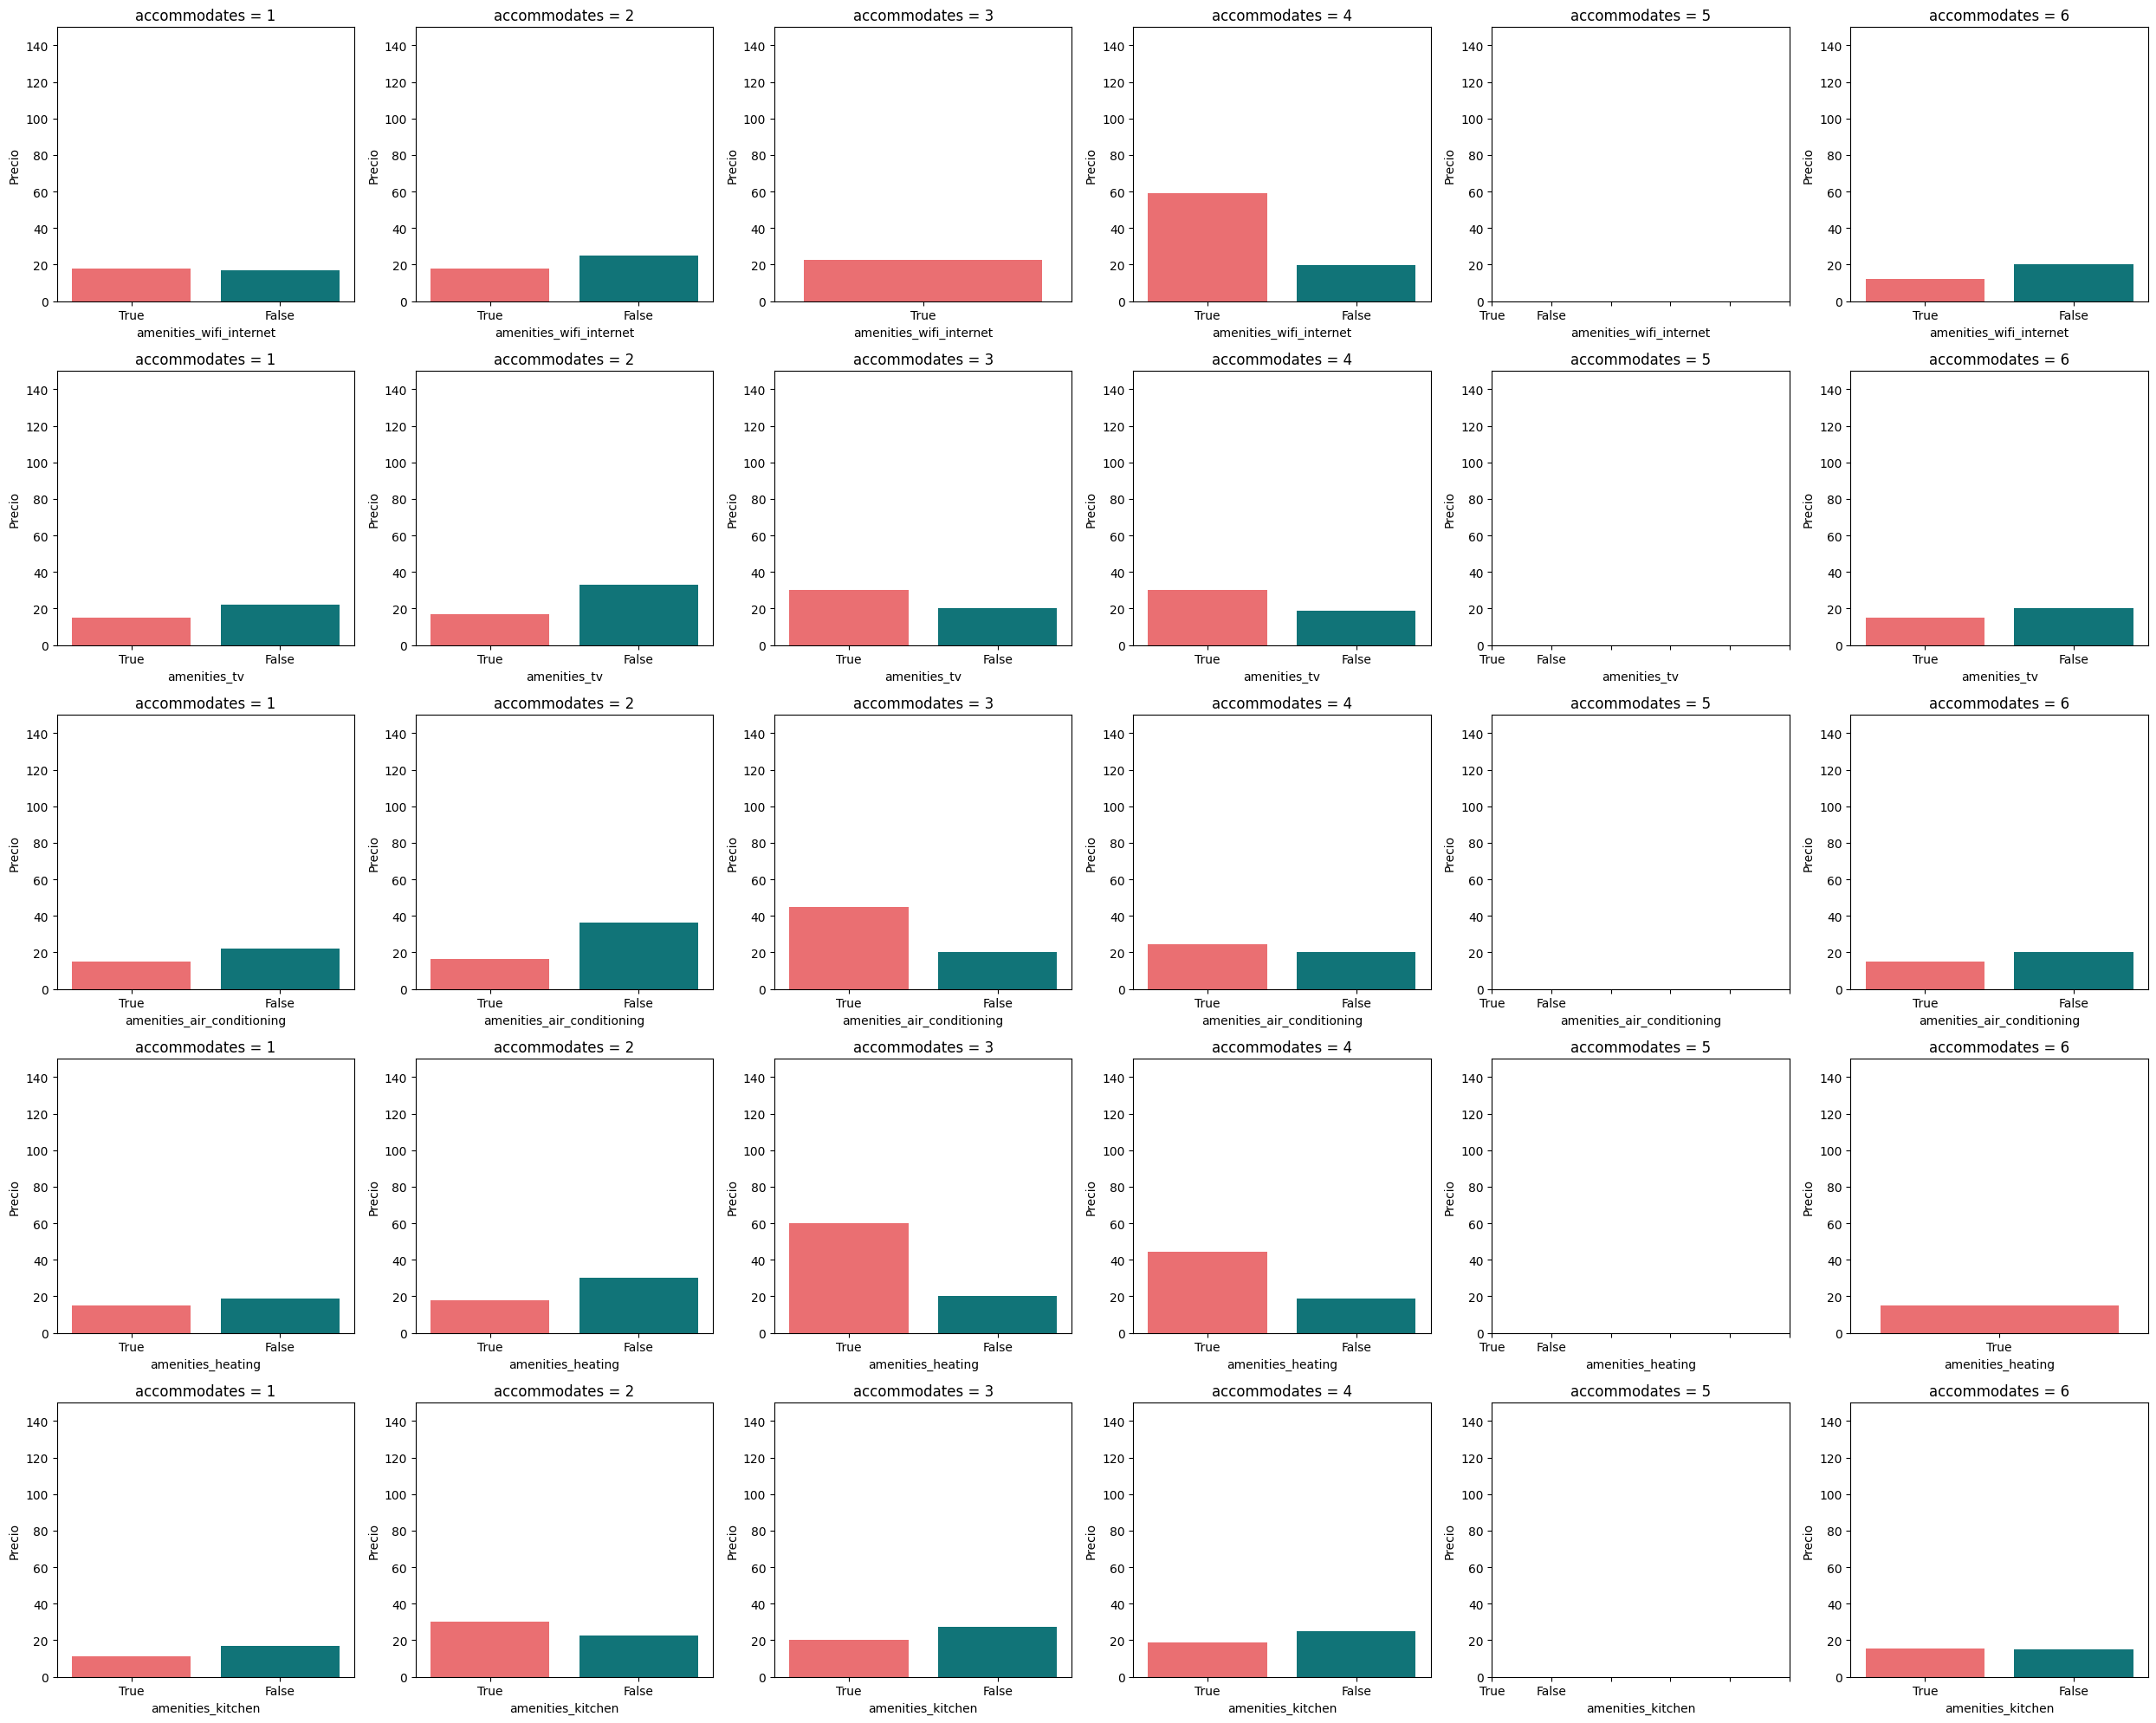

In [14]:
# GRAFICO COMPARATIVO PARA HABITACIÓN COMPARTIDA DE MEDIANA SEGUN TIENE O NO AMENITIES 
# Y SI ACOMMODATES 1,2,3,4,5 o 6 PERSONAS

# Lista de columnas amenities a considerar
amenities_columns = ['amenities_wifi_internet', 'amenities_tv', 'amenities_air_conditioning', 'amenities_heating', 'amenities_kitchen']

# Crear el gráfico de barras
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25, 20))

# Iterar sobre cada columna de amenities
for i, column in enumerate(amenities_columns):
    for j, accommodates in enumerate([1, 2, 3, 4, 5, 6]):
        # Filtrar el dataframe por room_type == 'shared_room'
        df_filtered = df_completo[(df_completo['room_type'] == 'shared_room') & (df_completo['accommodates'] == accommodates) & (df_completo['price'] <= 70)]
        
        # Calcular la mediana del precio agrupado por la columna dummie
        median_prices = df_filtered.groupby(column)['price'].median().reset_index()
        
        # Ordenar los valores dummies
        median_prices = median_prices.sort_values(by=column)
        
        # Crear el gráfico de barras
        sns.barplot(data=median_prices, x=column, y='price', palette=['#FF5A5F', '#008489'], ax=axes[i, j], hue_order=[True, False])
        axes[i, j].set_ylim(0, 150)
        axes[i, j].set_ylabel('Precio')
        axes[i, j].set_xlabel(column)
        axes[i, j].set_xticklabels(['True', 'False'])
        axes[i, j].set_title(f'accommodates = {accommodates}')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
print('Mediana de precio de habitación compartida según comodidades, teniendo en cuenta el rango de precios de 0 a 70 euros, y cantidad de personas')
plt.show()


In [15]:
# Contar el número de shared_room que acomodan 3 personas y tienen un precio de menos de 70 euros y no tienen WIFI
num_shared_room_3_under_70_no_wifi = df_completo[(df_completo['room_type'] == 'shared_room') & 
                                                 (df_completo['accommodates'] == 3) & 
                                                 (df_completo['price'] < 70) &
                                                 (df_completo['amenities_wifi_internet'] == False)].shape[0]

# Contar el número de shared_room que acomodan 5 personas y tienen un precio de menos de 70 euros
num_shared_room_5_under_70 = df_completo[(df_completo['room_type'] == 'shared_room') & 
                                          (df_completo['accommodates'] == 5) & 
                                          (df_completo['price'] < 70)].shape[0]

# Contar el número de shared_room que acomodan 6 personas, tienen un precio de menos de 70 euros y no tienen calefacción
num_shared_room_6_under_70_no_heating = df_completo[(df_completo['room_type'] == 'shared_room') & 
                                                    (df_completo['accommodates'] == 6) & 
                                                    (df_completo['price'] < 70) &
                                                    (df_completo['amenities_heating'] == False)].shape[0]

print(f"El número de shared_room que acomodan 3 personas y tienen un precio de menos de 70 euros y no tienen WIFI es: {num_shared_room_3_under_70_no_wifi}")
print(f"El número de shared_room que acomodan 6 personas y tienen un precio de menos de 70 euros es: {num_shared_room_5_under_70}")
print(f"El número de shared_room que acomodan 6 personas, tienen un precio de menos de 70 euros y no tienen calefacción es: {num_shared_room_6_under_70_no_heating}")


El número de shared_room que acomodan 3 personas y tienen un precio de menos de 70 euros y no tienen WIFI es: 0
El número de shared_room que acomodan 6 personas y tienen un precio de menos de 70 euros es: 0
El número de shared_room que acomodan 6 personas, tienen un precio de menos de 70 euros y no tienen calefacción es: 0


No hay habitación compartida, de 3 personas, listada sin wifi, por lo tanto solo muestra el valor True.  
No hay habitación compartida, de 6 personas, listada sin calefacción, por lo tanto solo muestra el valor True.  
No hay habitaciones compartidas de 5 personas, listadas por menos de 70 euros. 

In [16]:
def difference_in_median(column, accommodates, max_price=None):
    # Filtrar el dataframe
    df_filtered = df_completo[(df_completo['room_type'] == 'shared_room') & 
                              (df_completo['accommodates'] == accommodates)]
    if max_price:
        df_filtered = df_filtered[df_filtered['price'] <= max_price]
    
    # Calcular la mediana del precio para las habitaciones compartidas con y sin la columna dada
    median_with_column = df_filtered[df_filtered[column] == True]['price'].median()
    median_without_column = df_filtered[df_filtered[column] == False]['price'].median()
    
    # Calcular la diferencia en la mediana
    median_difference = median_with_column - median_without_column
    
    return median_difference

# Contar el número de shared_room que acomodan 5 personas y tienen un precio de menos de 70 euros
num_shared_room_5_under_70 = df_completo[(df_completo['room_type'] == 'shared_room') & 
                                         (df_completo['accommodates'] == 5) & 
                                         (df_completo['price'] < 70)].shape[0]

# Contar el número de shared_room que acomodan 6 personas y tienen un precio de menos de 70 euros
num_shared_room_6_under_70 = df_completo[(df_completo['room_type'] == 'shared_room') & 
                                         (df_completo['accommodates'] == 6) & 
                                         (df_completo['price'] < 70)].shape[0]

print(f"El número de shared_room que acomodan 5 personas y tienen un precio de menos de 70 euros es: {num_shared_room_5_under_70}")
print(f"El número de shared_room que acomodan 6 personas y tienen un precio de menos de 70 euros es: {num_shared_room_6_under_70}")

# Calcular la diferencia en la mediana para amenities_wifi_internet
print("Diferencia en la mediana para amenities_wifi_internet:")
print("------------------------------------------------------")
print(f"Acomodates 3 personas: {difference_in_median('amenities_wifi_internet', 3, 70)}")
print(f"Acomodates 4 personas: {difference_in_median('amenities_wifi_internet', 4, 70)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_tv
print("Diferencia en la mediana para amenities_tv:")
print("------------------------------------------------------")
print(f"Acomodates 3 personas: {difference_in_median('amenities_tv', 3, 70)}")
print(f"Acomodates 4 personas: {difference_in_median('amenities_tv', 4, 70)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_air_conditioning
print("Diferencia en la mediana para amenities_air_conditioning:")
print("------------------------------------------------------")
print(f"Acomodates 3 personas: {difference_in_median('amenities_air_conditioning', 3, 70)}")
print(f"Acomodates 4 personas: {difference_in_median('amenities_air_conditioning', 4, 70)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_heating
print("Diferencia en la mediana para amenities_heating:")
print("------------------------------------------------------")
print(f"Acomodates 3 personas: {difference_in_median('amenities_heating', 3, 70)}")
print(f"Acomodates 4 personas: {difference_in_median('amenities_heating', 4, 70)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_kitchen
print("Diferencia en la mediana para amenities_kitchen:")
print("------------------------------------------------------")
print(f"Acomodates 2 personas: {difference_in_median('amenities_kitchen', 2, 70)}")
print("------------------------------------------------------")


El número de shared_room que acomodan 5 personas y tienen un precio de menos de 70 euros es: 0
El número de shared_room que acomodan 6 personas y tienen un precio de menos de 70 euros es: 9
Diferencia en la mediana para amenities_wifi_internet:
------------------------------------------------------
Acomodates 3 personas: nan
Acomodates 4 personas: -39.5
------------------------------------------------------
Diferencia en la mediana para amenities_tv:
------------------------------------------------------
Acomodates 3 personas: -10.0
Acomodates 4 personas: -11.0
------------------------------------------------------
Diferencia en la mediana para amenities_air_conditioning:
------------------------------------------------------
Acomodates 3 personas: -25.0
Acomodates 4 personas: -4.5
------------------------------------------------------
Diferencia en la mediana para amenities_heating:
------------------------------------------------------
Acomodates 3 personas: -40.0
Acomodates 4 person

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3126170865.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3126170865.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3126170865.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3126170865.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z

Distribución de precios de habitación compartida según comodidades, para un rango de precios de 0 a 70 euros, y según cantidad de personas


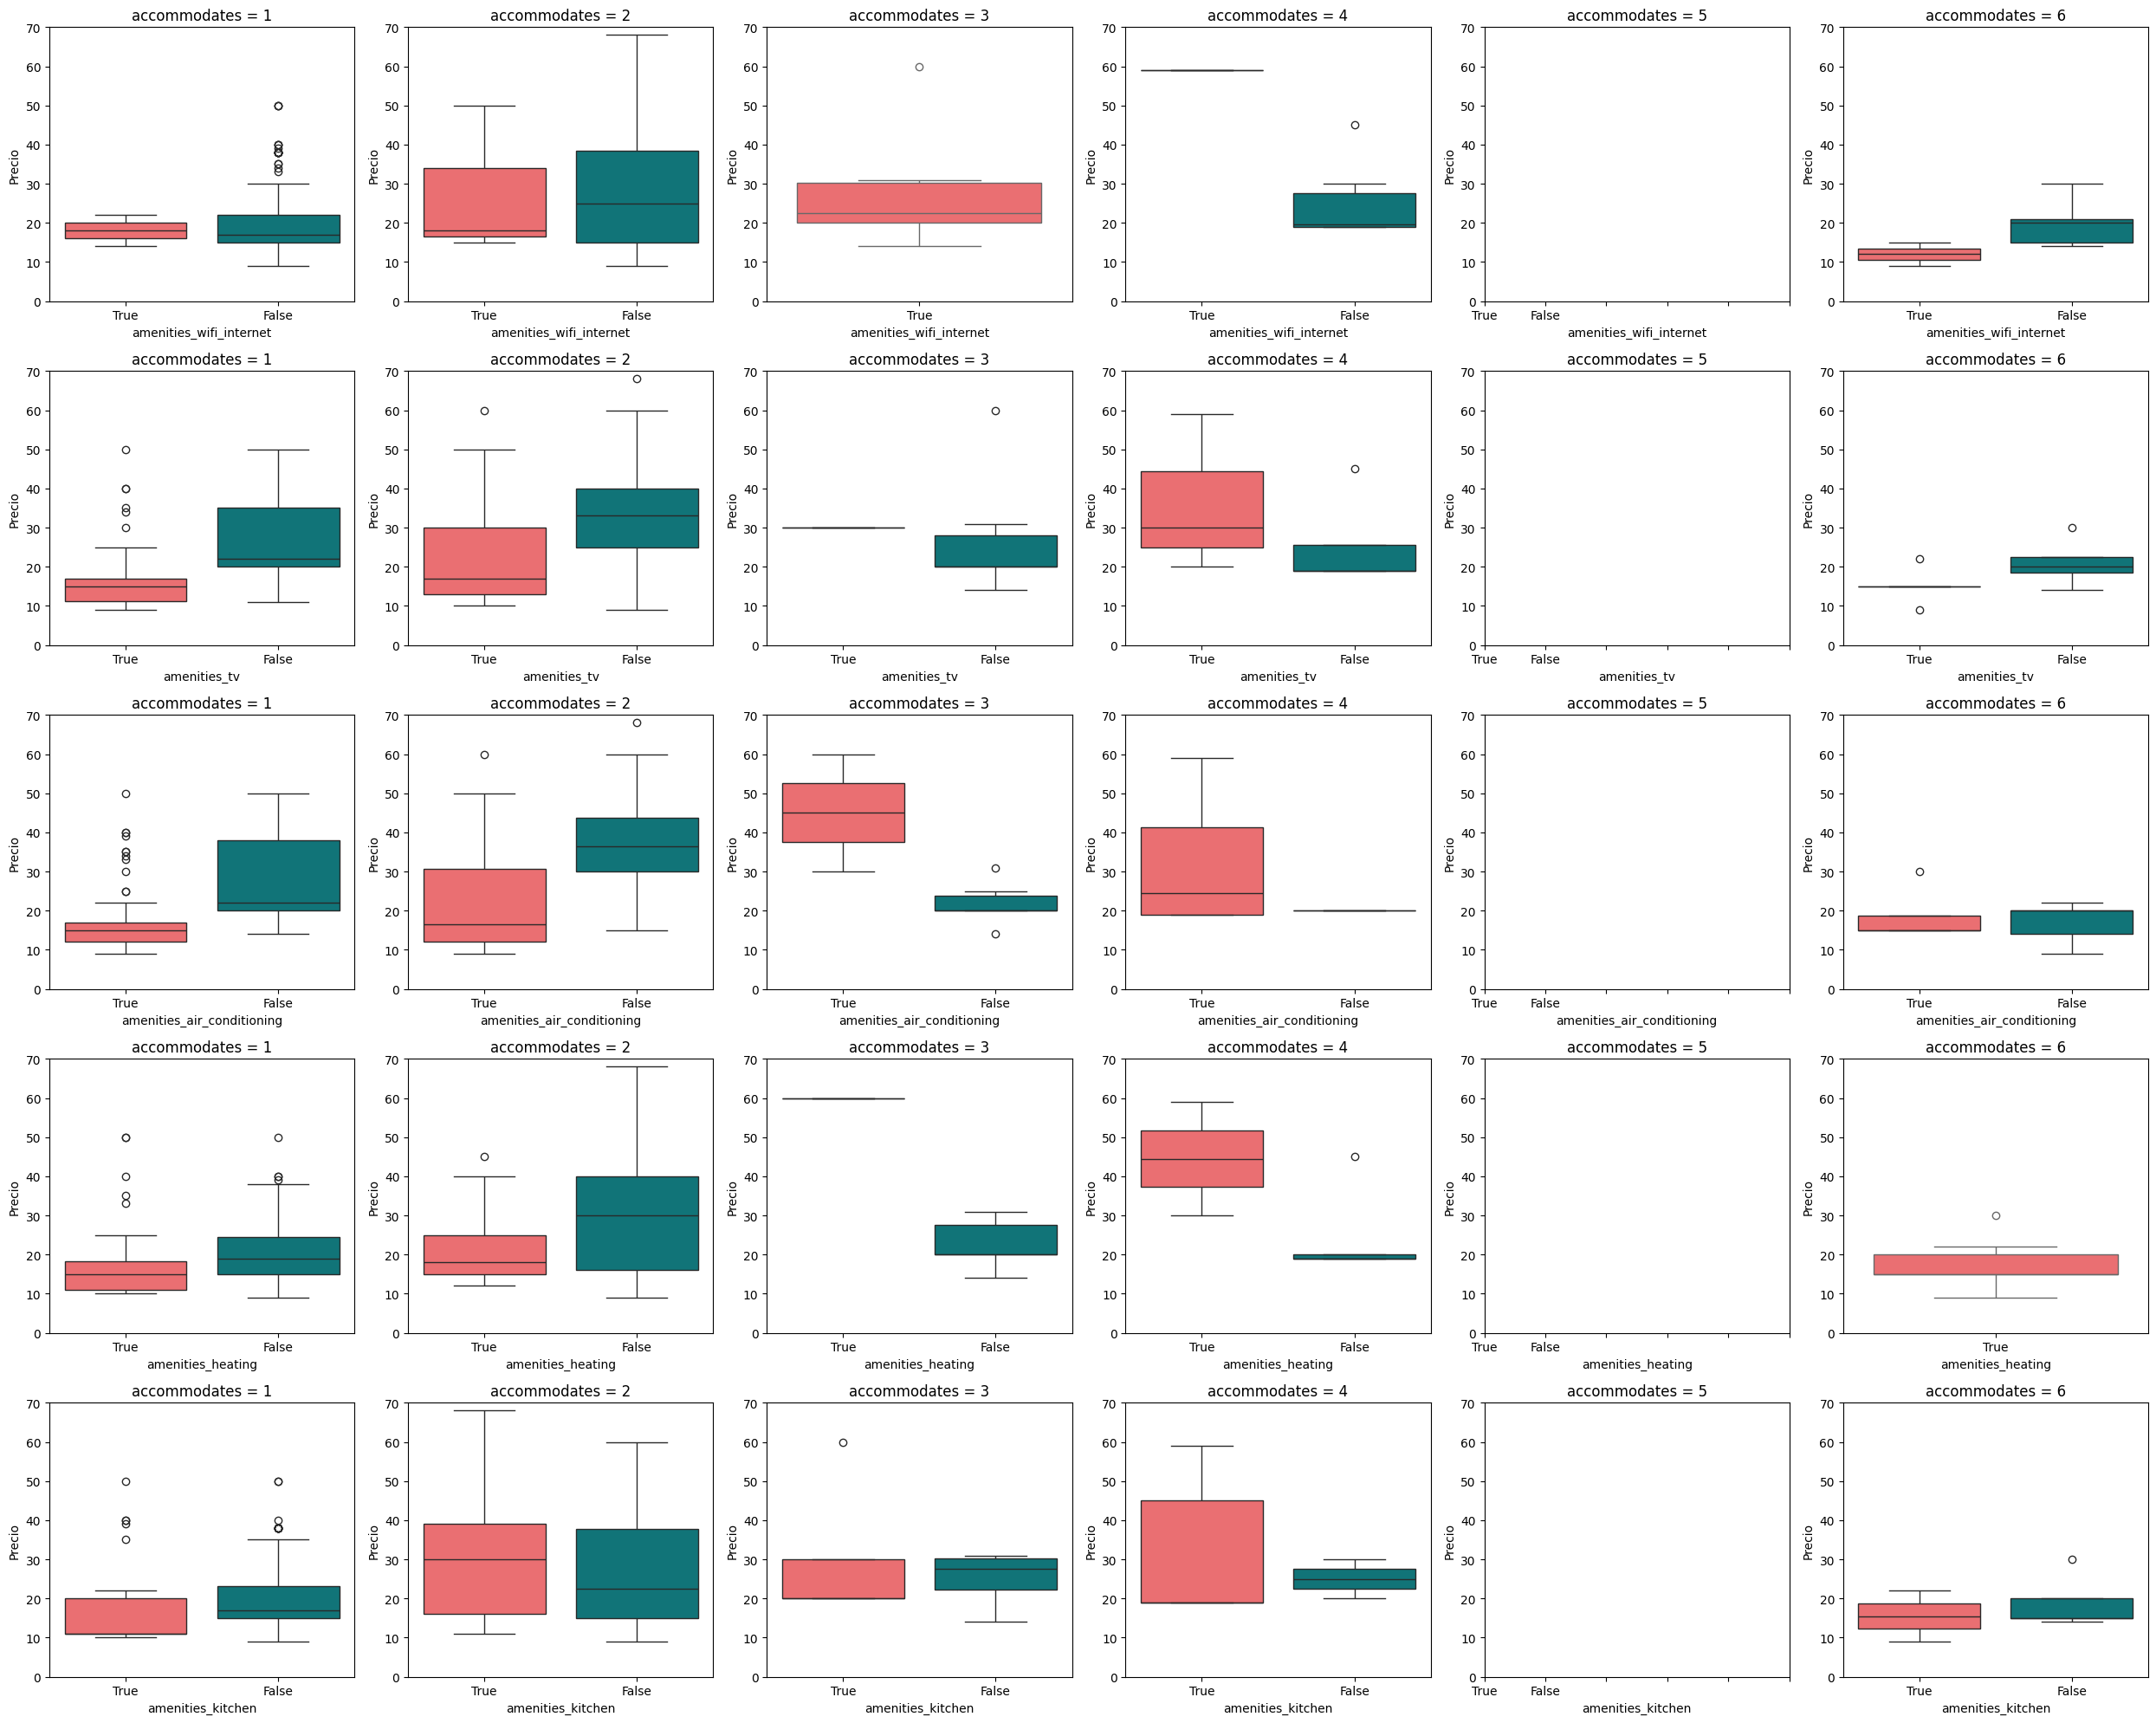

In [26]:
# GRAFICO COMPARATIVO PARA HABITACIÓN COMPARTIDA DE BOXPLOTS SEGÚN TIENE O NO AMENITIES 
# Y SI ACOMMODATES 1,2,3,4,5 o 6 PERSONAS

# Lista de columnas amenities a considerar
amenities_columns = ['amenities_wifi_internet', 'amenities_tv', 'amenities_air_conditioning', 'amenities_heating', 'amenities_kitchen']

# Crear el gráfico de cajas
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25, 20))

# Iterar sobre cada columna de amenities
for i, column in enumerate(amenities_columns):
    for j, accommodates in enumerate([1, 2, 3, 4, 5, 6]):
        # Filtrar el dataframe por room_type == 'shared_room'
        df_filtered = df_completo[(df_completo['room_type'] == 'shared_room') & (df_completo['accommodates'] == accommodates) & (df_completo['price'] <= 70)]
        
        # Crear el gráfico de cajas
        sns.boxplot(data=df_filtered, x=column, y='price', palette=['#FF5A5F', '#008489'], ax=axes[i, j])
        axes[i, j].set_ylim(0, 70)
        axes[i, j].set_ylabel('Precio')
        axes[i, j].set_xlabel(column)
        axes[i, j].set_xticklabels(['True', 'False'])
        axes[i, j].set_title(f'accommodates = {accommodates}')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
print('Distribución de precios de habitación compartida según comodidades, para un rango de precios de 0 a 70 euros, y según cantidad de personas')
plt.show()


<font size="6" color="#FF5A5F">CONCLUSIONES DE AMENITIES PARA HABITACIÓN COMPARTIDA (comodidades): </font>


Para habitación compartida:  
- Tener WIFI puede aumentar el precio para habitaciones compartidas de 4 personas, en 39.5 euros de mediana.
- Tener TV puede aumentar el precio para habitaciones compartidas de 3 personas, 10 euros y 4 personas, 11 euros de mediana correspondientemente.
- Tener AIRE ACONDICIONADO puede aumentar el precio para habitaciones compartidas de 3 personas, 25 euros de mediana y de 4 personas, 4.5 euros de mediana.
- Tener CALEFACCIÓN puede aumentar el precio para habitaciones compartidas de 3 personas, 40 euros de mediana y para 4 personas, 25 euros de mediana.
- Tener COCINA puede aumentar el precio para habitaciones compartidas de 2 personas, 7.5 euros de mediana.

---------------

- Habitación privada

Considerando el rango de precios de 0 a 120 euros

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3675695873.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3675695873.py:27: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3675695873.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3675695873.py:27: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z

Mediana de precio de habitación privada según comodidades, teniendo en cuenta el rango de precios de 0 a 120 euros, y cantidad de personas


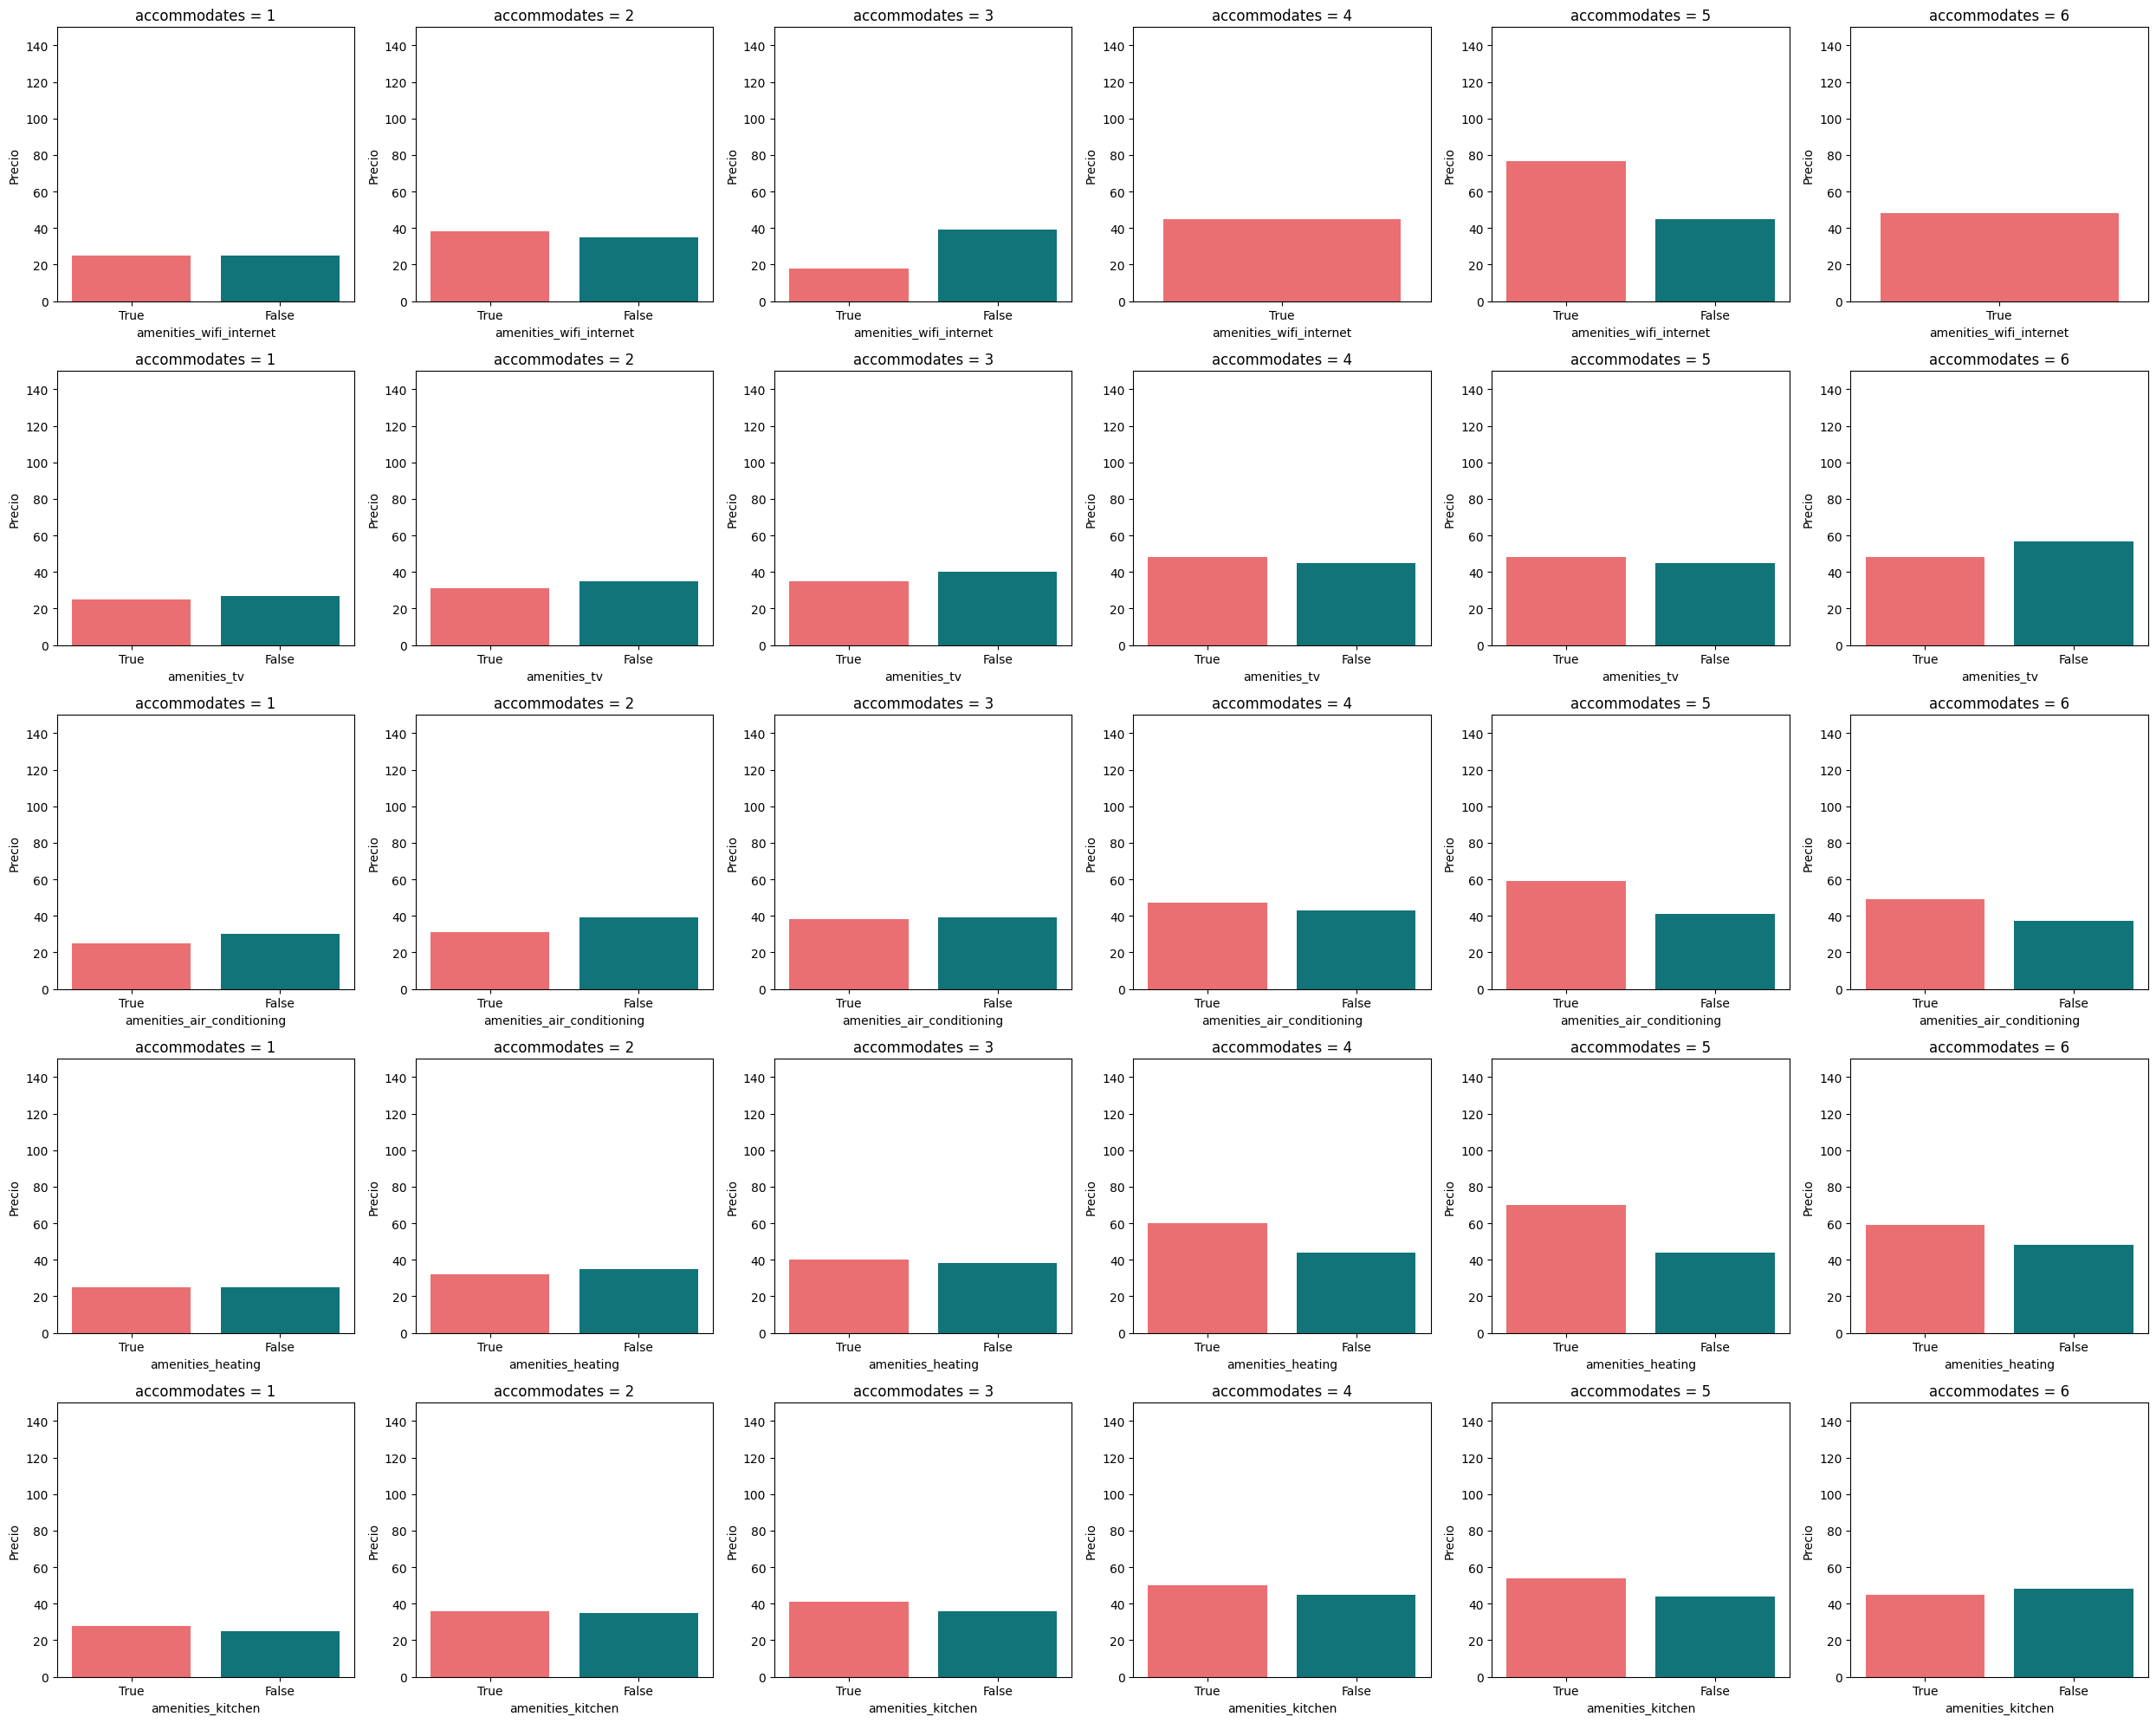

In [18]:
# GRAFICO COMPARATIVO PARA HABITACIÓN PRIVADA DE MEDIANA SEGUN TIENE O NO AMENITIES 
# Y SI ACOMMODATES 1,2,3,4,5 o 6 PERSONAS

# Lista de columnas amenities a considerar
amenities_columns = ['amenities_wifi_internet', 'amenities_tv', 'amenities_air_conditioning', 'amenities_heating', 'amenities_kitchen']

# Crear el gráfico de barras
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25, 20))

# Iterar sobre cada columna de amenities
for i, column in enumerate(amenities_columns):
    for j, accommodates in enumerate([1, 2, 3, 4, 5, 6]):
        # Filtrar el dataframe por room_type == 'private_room'
        df_filtered = df_completo[(df_completo['room_type'] == 'private_room') & (df_completo['accommodates'] == accommodates) & (df_completo['price'] <= 120)]
        
        # Calcular la mediana del precio agrupado por la columna dummie
        median_prices = df_filtered.groupby(column)['price'].median().reset_index()
        
        # Ordenar los valores dummies
        median_prices = median_prices.sort_values(by=column)
        
        # Crear el gráfico de barras
        sns.barplot(data=median_prices, x=column, y='price', palette=['#FF5A5F', '#008489'], ax=axes[i, j], hue_order=[True, False])
        axes[i, j].set_ylim(0, 150)
        axes[i, j].set_ylabel('Precio')
        axes[i, j].set_xlabel(column)
        axes[i, j].set_xticklabels(['True', 'False'])
        axes[i, j].set_title(f'accommodates = {accommodates}')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
print('Mediana de precio de habitación privada según comodidades, teniendo en cuenta el rango de precios de 0 a 120 euros, y cantidad de personas')
plt.show()

In [19]:
def difference_in_median(column, accommodates, max_price=None):
    # Filtrar el dataframe
    df_filtered = df_completo[(df_completo['room_type'] == 'private_room') & 
                              (df_completo['accommodates'] == accommodates)]
    if max_price:
        df_filtered = df_filtered[df_filtered['price'] <= max_price]
    
    # Calcular la mediana del precio para las habitaciones privadas con y sin la columna dada
    median_with_column = df_filtered[df_filtered[column] == True]['price'].median()
    median_without_column = df_filtered[df_filtered[column] == False]['price'].median()
    
    # Calcular la diferencia en la mediana
    median_difference = median_with_column - median_without_column
    
    return median_difference

# Contar el número de private_room que acomodan 5 personas y tienen un precio de menos de 120 euros
num_private_room_5_under_120 = df_completo[(df_completo['room_type'] == 'private_room') & 
                                         (df_completo['accommodates'] == 5) & 
                                         (df_completo['price'] < 120)].shape[0]

# Contar el número de private_room que acomodan 6 personas y tienen un precio de menos de 120 euros
num_private_room_6_under_120 = df_completo[(df_completo['room_type'] == 'private_room') & 
                                         (df_completo['accommodates'] == 6) & 
                                         (df_completo['price'] < 120)].shape[0]

print(f"El número de private_room que acomodan 5 personas y tienen un precio de menos de 120 euros es: {num_private_room_5_under_120}")
print(f"El número de private_room que acomodan 6 personas y tienen un precio de menos de 120 euros es: {num_private_room_6_under_120}")

# Calcular la diferencia en la mediana para amenities_wifi_internet
print("Diferencia en la mediana para amenities_wifi_internet:")
print("------------------------------------------------------")
print("Para habitación privada:")
print("- Tener WIFI puede aumentar el precio para habitaciones privadas de 2 personas y 5 personas.")
print(f"Acomodates 2 personas: {difference_in_median('amenities_wifi_internet', 2, 120)}")
print(f"Acomodates 5 personas: {difference_in_median('amenities_wifi_internet', 5, 120)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_tv
print("Diferencia en la mediana para amenities_tv:")
print("------------------------------------------------------")
print("Para habitación privada:")
print("- Tener TV puede aumentar el precio ligeramentepara habitaciones privadas de 4 y 5 personas.")
print(f"Acomodates 4 personas: {difference_in_median('amenities_tv', 4, 120)}")
print(f"Acomodates 5 personas: {difference_in_median('amenities_tv', 5, 120)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_air_conditioning
print("Diferencia en la mediana para amenities_air_conditioning:")
print("------------------------------------------------------")
print("Para habitación privada:")
print("- Tener AIRE ACONDICIONADO puede aumentar el precio para 4, 5 y 6 personas.")
print(f"Acomodates 4 personas: {difference_in_median('amenities_air_conditioning', 4, 120)}")
print(f"Acomodates 5 personas: {difference_in_median('amenities_air_conditioning', 5, 120)}")
print(f"Acomodates 6 personas: {difference_in_median('amenities_air_conditioning', 6, 120)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_heating
print("Diferencia en la mediana para amenities_heating:")
print("------------------------------------------------------")
print("Para habitación privada:")
print("- Tener CALEFACCIÓN puede aumentar el precio para 3, 4, 5 y 6 personas.")
print(f"Acomodates 3 personas: {difference_in_median('amenities_heating', 3, 120)}")
print(f"Acomodates 4 personas: {difference_in_median('amenities_heating', 4, 120)}")
print(f"Acomodates 5 personas: {difference_in_median('amenities_heating', 5, 120)}")
print(f"Acomodates 6 personas: {difference_in_median('amenities_heating', 6, 120)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_kitchen
print("Diferencia en la mediana para amenities_kitchen:")
print("------------------------------------------------------")
print("Para habitación privada:")
print("- Tener COCINA puede aumentar el precio para habitaciones privadas de 1, 2, 3, 4 y 5 personas.")
print(f"Acomodates 1 personas: {difference_in_median('amenities_kitchen', 1, 120)}")
print(f"Acomodates 2 personas: {difference_in_median('amenities_kitchen', 2, 120)}")
print(f"Acomodates 3 personas: {difference_in_median('amenities_kitchen', 3, 120)}")
print(f"Acomodates 4 personas: {difference_in_median('amenities_kitchen', 4, 120)}")
print(f"Acomodates 5 personas: {difference_in_median('amenities_kitchen', 5, 120)}")
print("------------------------------------------------------")


El número de private_room que acomodan 5 personas y tienen un precio de menos de 120 euros es: 33
El número de private_room que acomodan 6 personas y tienen un precio de menos de 120 euros es: 18
Diferencia en la mediana para amenities_wifi_internet:
------------------------------------------------------
Para habitación privada:
- Tener WIFI puede aumentar el precio para habitaciones privadas de 2 personas y 5 personas.
Acomodates 2 personas: -3.0
Acomodates 5 personas: -31.5
------------------------------------------------------
Diferencia en la mediana para amenities_tv:
------------------------------------------------------
Para habitación privada:
- Tener TV puede aumentar el precio ligeramentepara habitaciones privadas de 4 y 5 personas.
Acomodates 4 personas: -3.0
Acomodates 5 personas: -3.0
------------------------------------------------------
Diferencia en la mediana para amenities_air_conditioning:
------------------------------------------------------
Para habitación privada

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/4167052419.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/4167052419.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/4167052419.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/4167052419.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z

Distribución de precios de habitación privada según comodidades, para un rango de precios de 0 a 70 euros, y según cantidad de personas


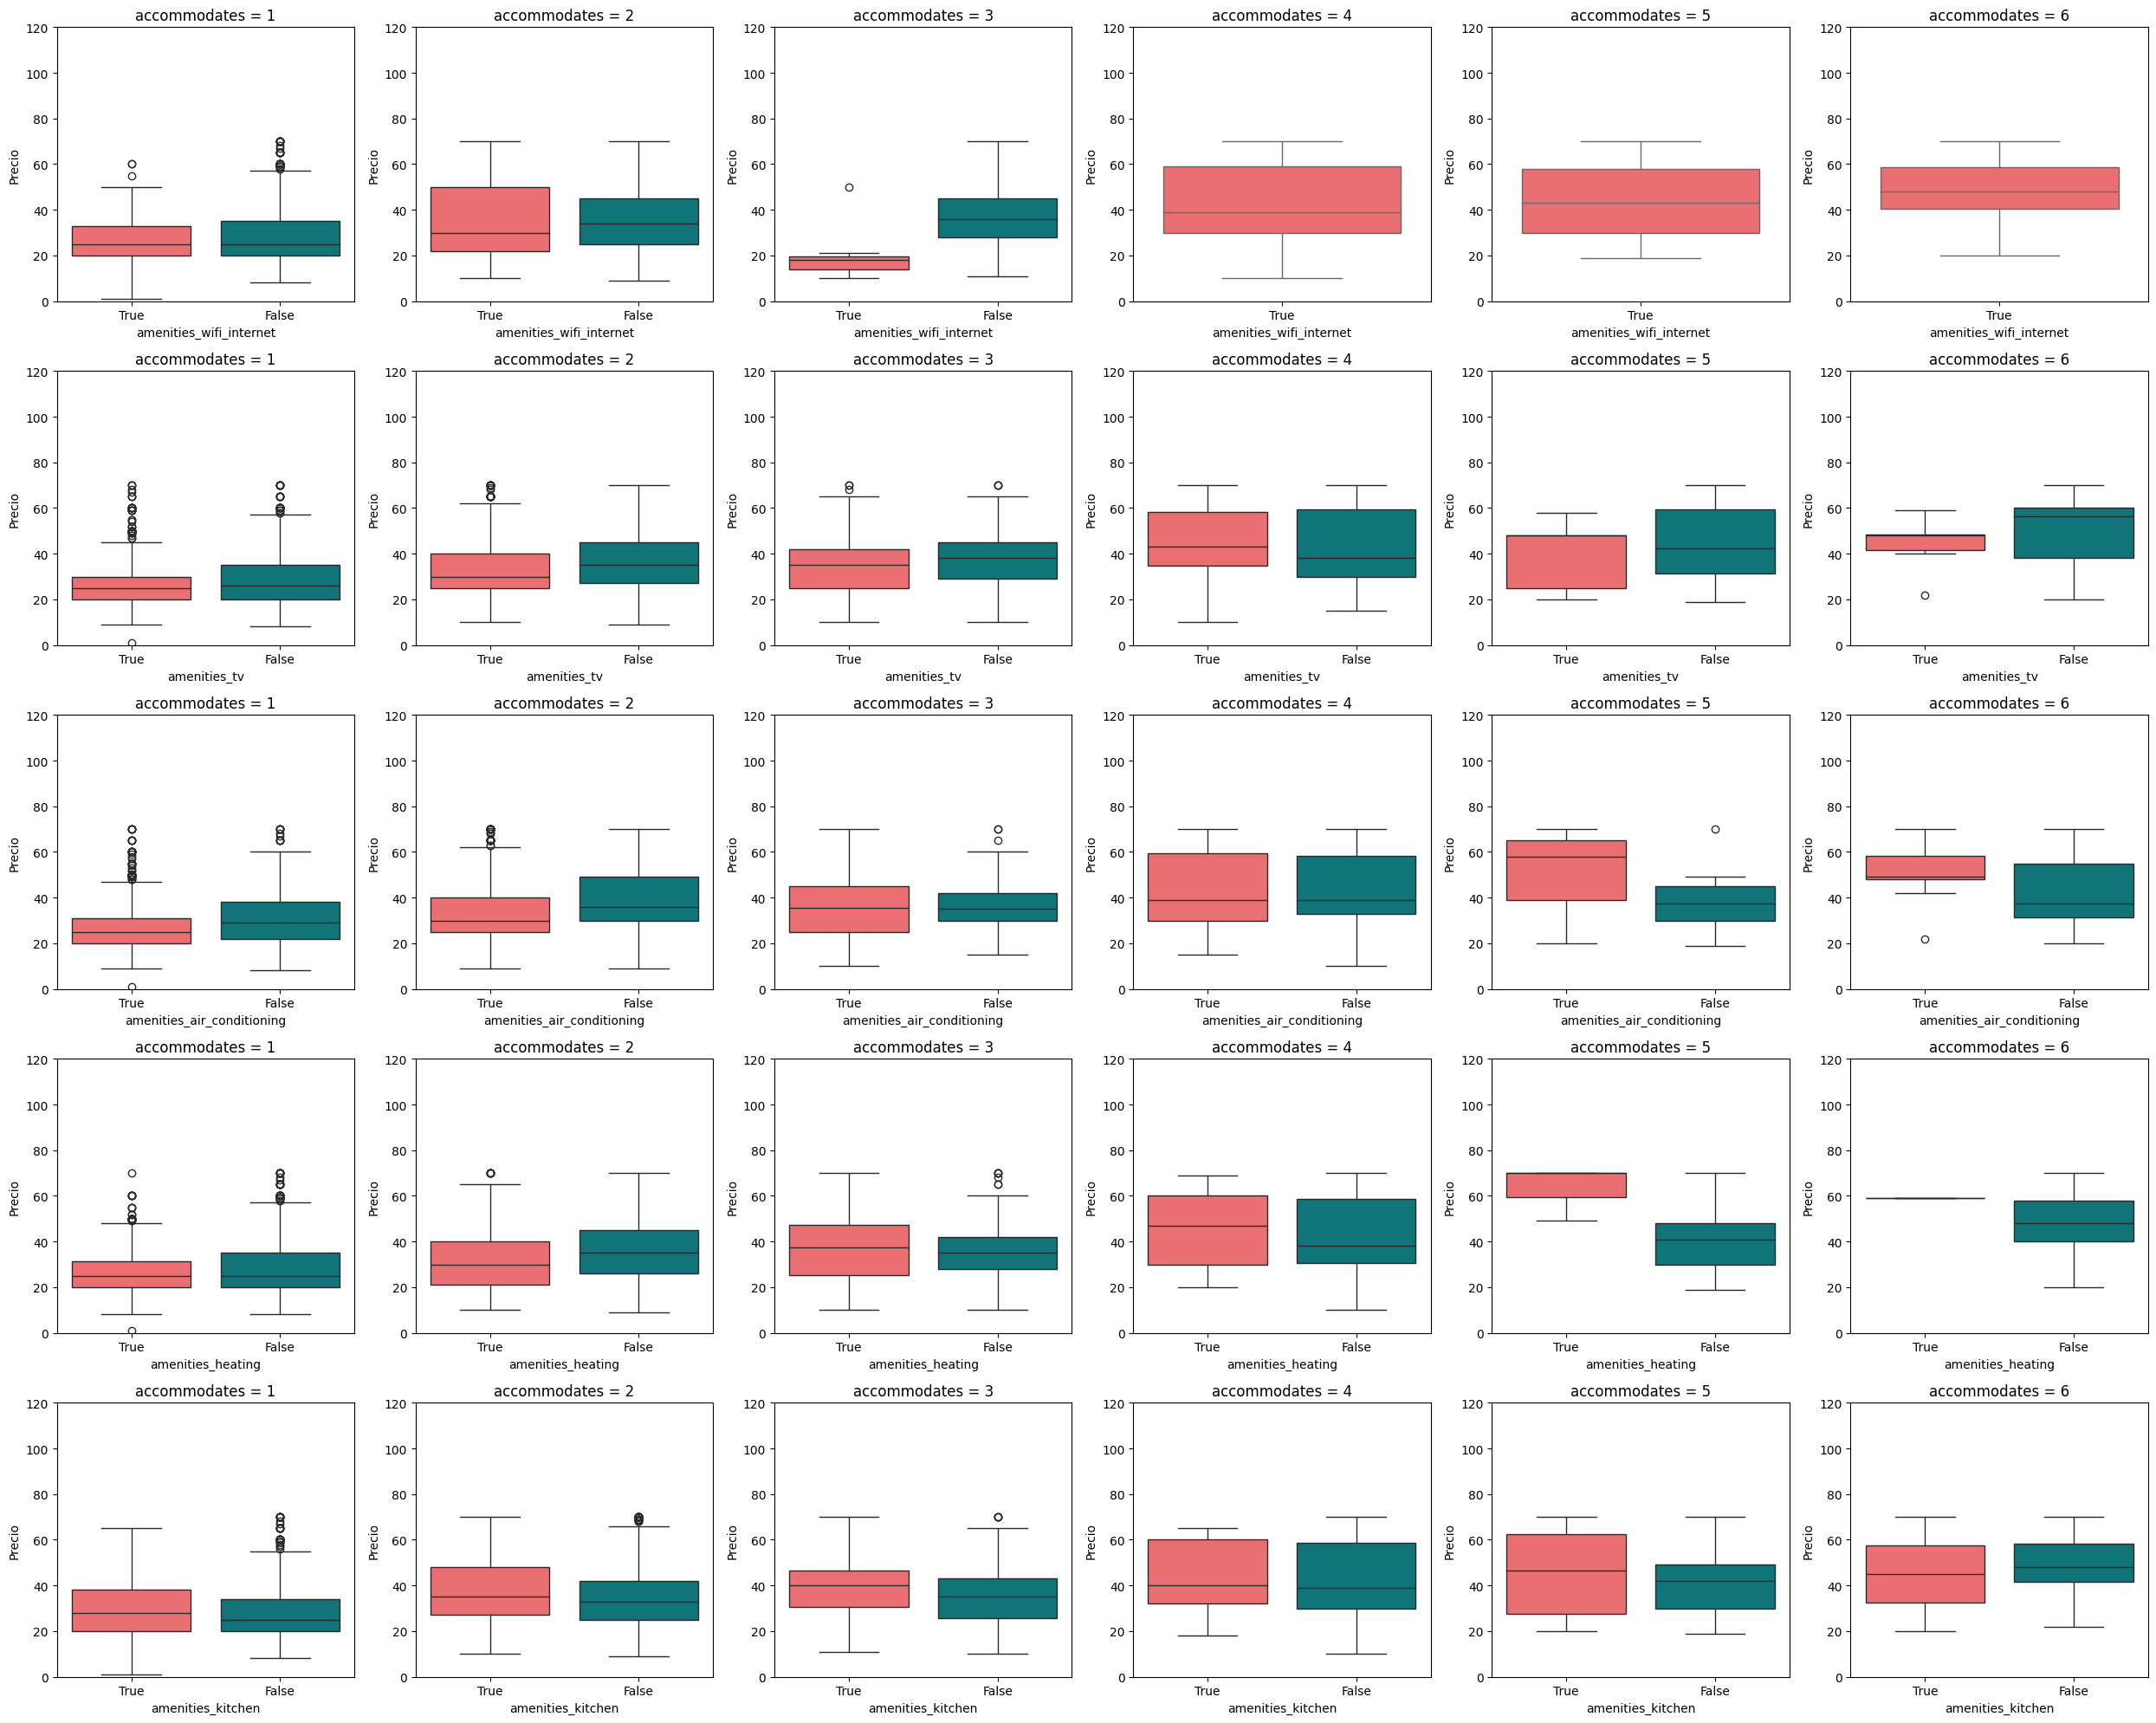

In [28]:
# GRAFICO COMPARATIVO PARA HABITACIÓN PRIVADA BOXPLOTS SEGÚN TIENE O NO AMENITIES 
# Y SI ACOMMODATES 1,2,3,4,5 o 6 PERSONAS

# Lista de columnas amenities a considerar
amenities_columns = ['amenities_wifi_internet', 'amenities_tv', 'amenities_air_conditioning', 'amenities_heating', 'amenities_kitchen']

# Crear el gráfico de cajas
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25, 20))

# Iterar sobre cada columna de amenities
for i, column in enumerate(amenities_columns):
    for j, accommodates in enumerate([1, 2, 3, 4, 5, 6]):
        # Filtrar el dataframe por room_type == 'private_room'
        df_filtered = df_completo[(df_completo['room_type'] == 'private_room') & (df_completo['accommodates'] == accommodates) & (df_completo['price'] <= 70)]
        
        # Crear el gráfico de cajas
        sns.boxplot(data=df_filtered, x=column, y='price', palette=['#FF5A5F', '#008489'], ax=axes[i, j])
        axes[i, j].set_ylim(0, 120)
        axes[i, j].set_ylabel('Precio')
        axes[i, j].set_xlabel(column)
        axes[i, j].set_xticklabels(['True', 'False'])
        axes[i, j].set_title(f'accommodates = {accommodates}')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
print('Distribución de precios de habitación privada según comodidades, para un rango de precios de 0 a 70 euros, y según cantidad de personas')
plt.show()


<font size="6" color="#FF5A5F">CONCLUSIONES DE AMENITIES PARA HABITACIÓN PRIVADA (comodidades): </font>


Para habitación privada:  
- Tener WIFI puede aumentar el precio para habitaciones privadas que acomoden a 2 personas, 3 euros de mediana y 5 personas 31.5 euros de mediana. No hay habitaciones privadas que acomoden a 4 y 6 personas sin WIFI.
- Tener TV puede aumentar el precio para habitaciones privadas que acomoden a 4 personas, 3 euros de mediana y 5 personas, 3 euros de mediana.
- Tener AIRE ACONDICIONADO puede aumentar el precio para habitaciones privadas que acomoden a 4 personas, 4 euros de mediana, 5 personas, 18 euros de mediana y 6 personas, 11.5 euros de mediana.
- Tener CALEFACCIÓN puede aumentar el precio para habitaciones privadas que acomoden a 3 personas, 2 euros de mediana, 4 personas, 16 euros de mediana, 5 personas, 26 euros de mediana y 6 personas 11 euros de mediana.
- Tener COCINA puede aumentar el precio para habitaciones privadas 1 persona, 3 euros de mediana, 2 personas 1 euro de mediana, 3 personas, 5 euros de mediana, 4 personas 5 euros de mediana y 5 personas 10 euros de mediana. 

-----------

- Piso entero

Considerando el rango de precios de 0 a 300 euros.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3722514016.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3722514016.py:27: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3722514016.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3722514016.py:27: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z

Mediana de precio de piso entero según comodidades, teniendo en cuenta el rango de precios de 0 a 300 euros, y cantidad de personas


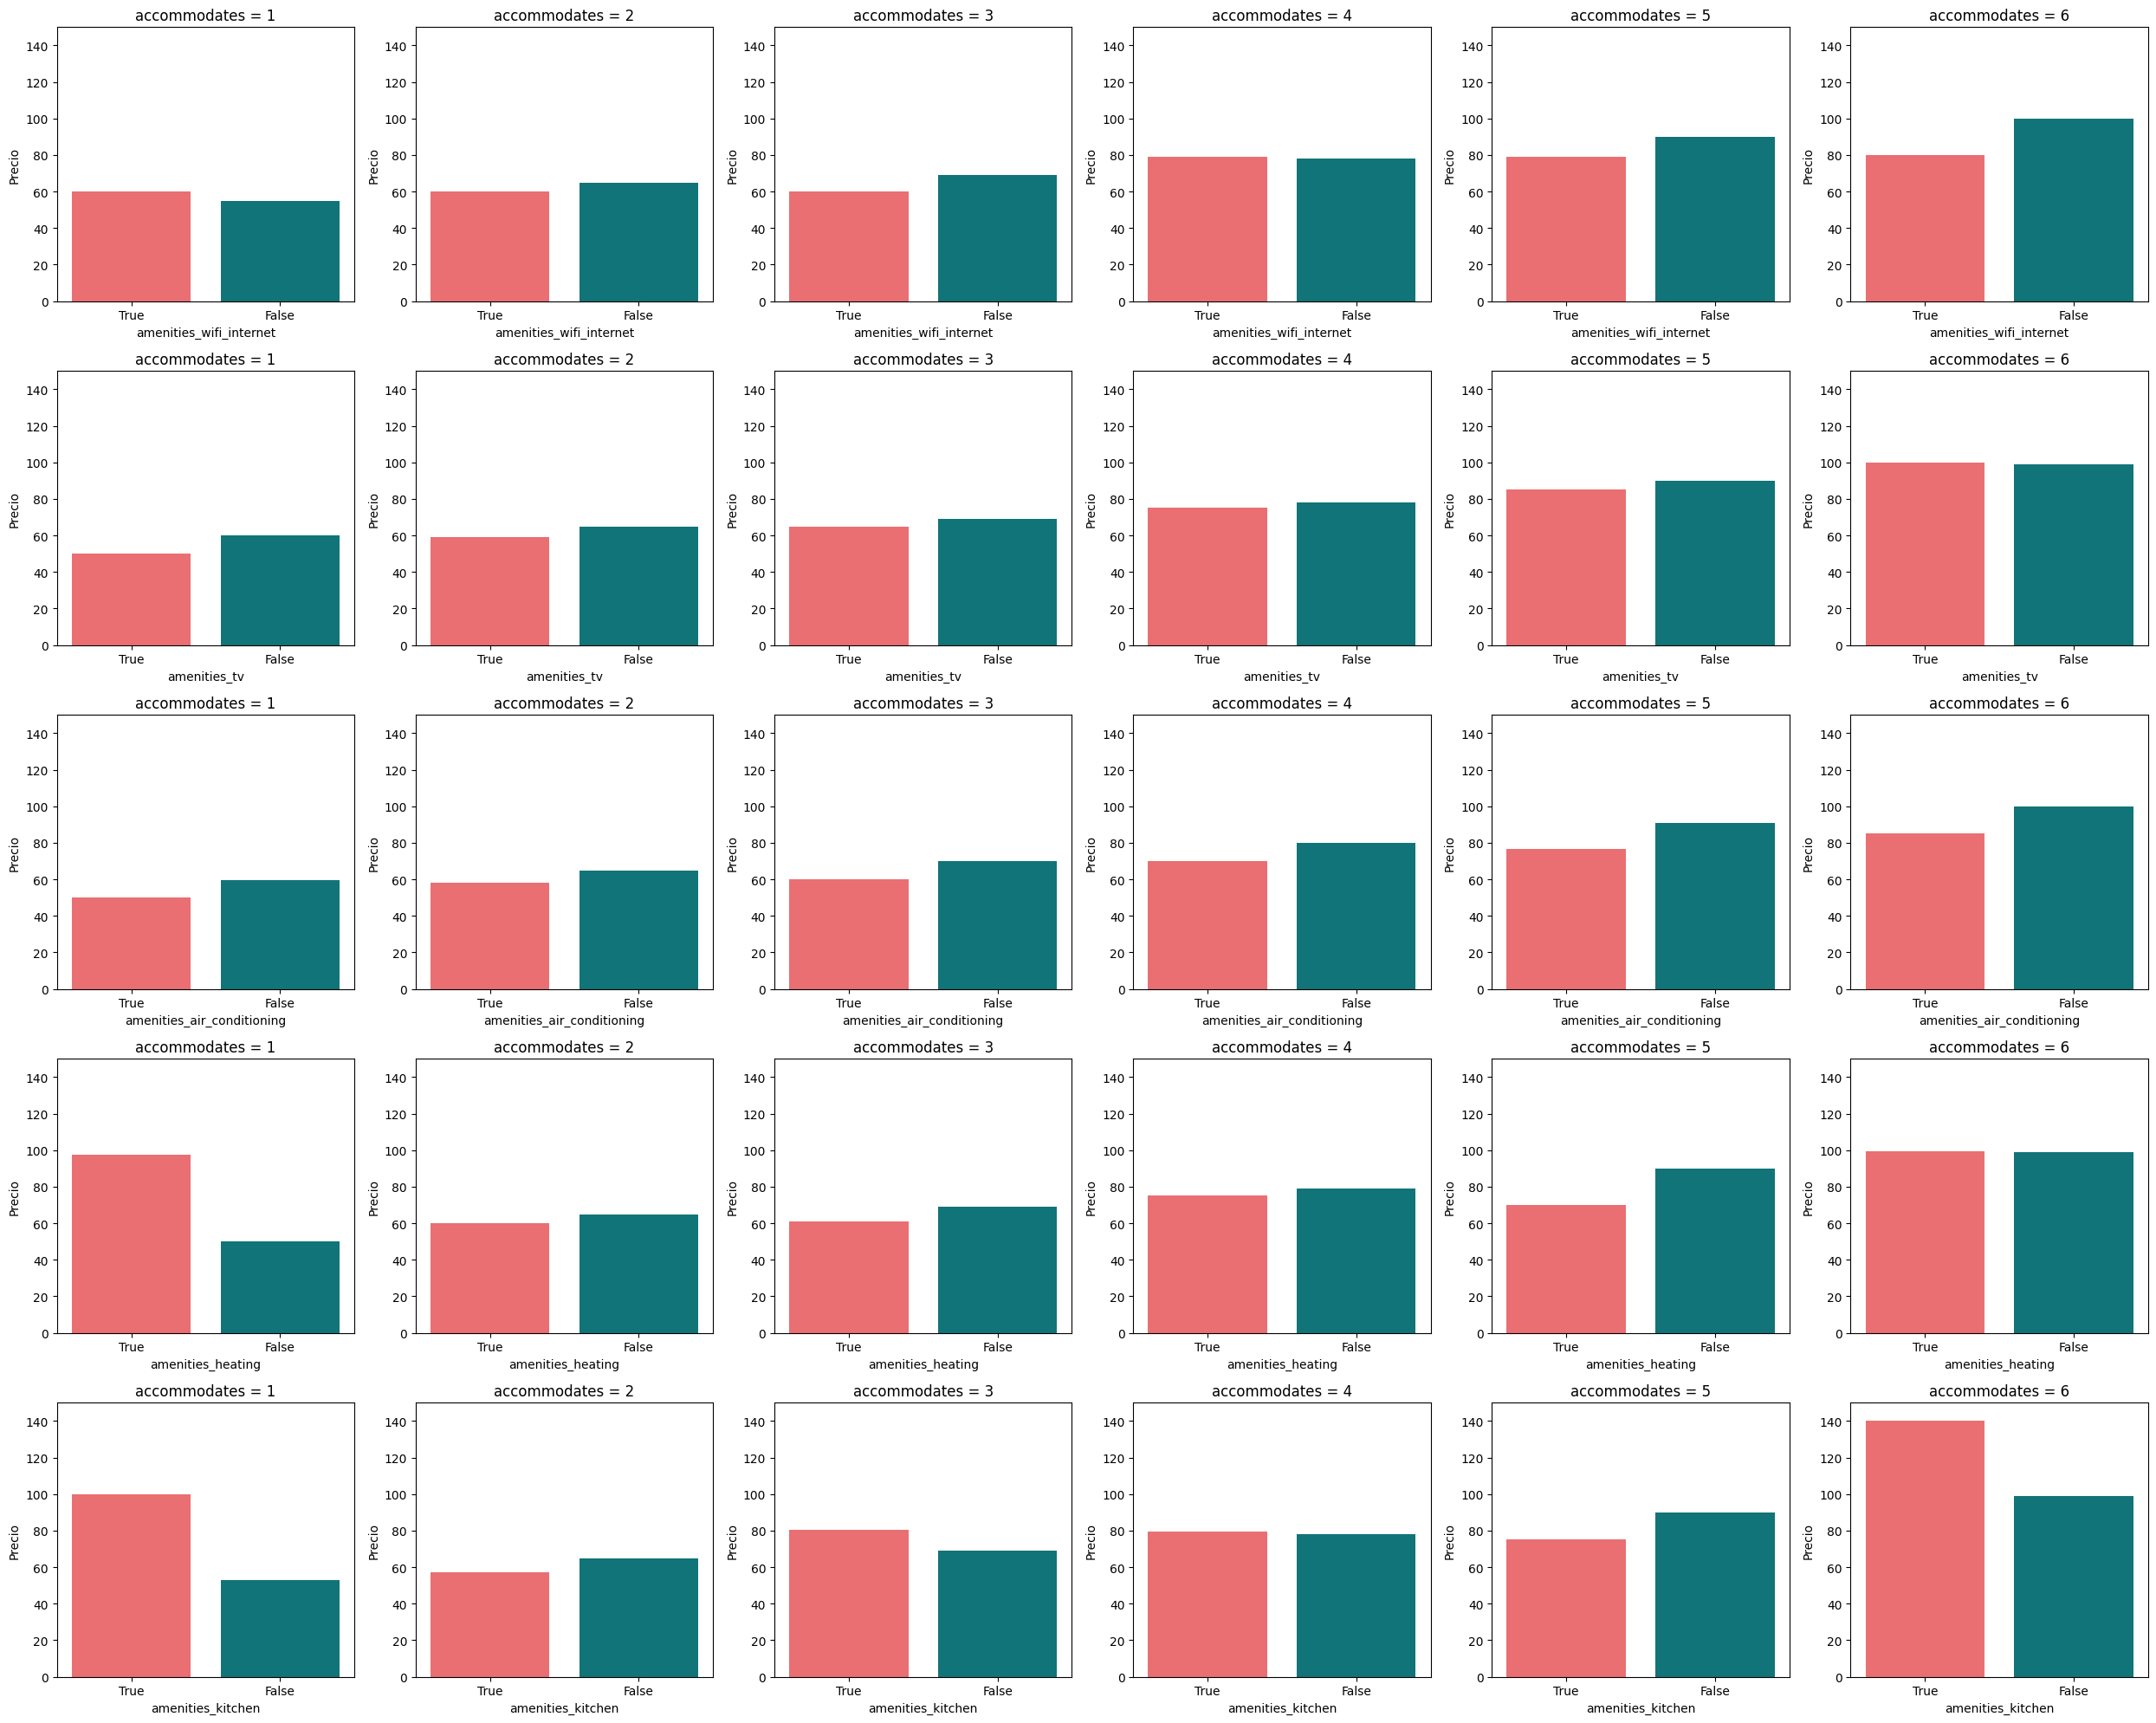

In [20]:
# GRAFICO COMPARATIVO PARA PISO/CASA ENTERA DE MEDIANA SEGUN TIENE O NO AMENITIES 
# Y SI ACOMMODATES 1,2,3,4,5 o 6 PERSONAS

# Lista de columnas amenities a considerar
amenities_columns = ['amenities_wifi_internet', 'amenities_tv', 'amenities_air_conditioning', 'amenities_heating', 'amenities_kitchen']

# Crear el gráfico de barras
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25, 20))

# Iterar sobre cada columna de amenities
for i, column in enumerate(amenities_columns):
    for j, accommodates in enumerate([1, 2, 3, 4, 5, 6]):
        # Filtrar el dataframe por room_type == 'entire_home_apt'
        df_filtered = df_completo[(df_completo['room_type'] == 'entire_home_apt') & (df_completo['accommodates'] == accommodates) & (df_completo['price'] <= 300)]
        
        # Calcular la mediana del precio agrupado por la columna dummie
        median_prices = df_filtered.groupby(column)['price'].median().reset_index()
        
        # Ordenar los valores dummies
        median_prices = median_prices.sort_values(by=column)
        
        # Crear el gráfico de barras
        sns.barplot(data=median_prices, x=column, y='price', palette=['#FF5A5F', '#008489'], ax=axes[i, j], hue_order=[True, False])
        axes[i, j].set_ylim(0, 150)
        axes[i, j].set_ylabel('Precio')
        axes[i, j].set_xlabel(column)
        axes[i, j].set_xticklabels(['True', 'False'])
        axes[i, j].set_title(f'accommodates = {accommodates}')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
print('Mediana de precio de piso entero según comodidades, teniendo en cuenta el rango de precios de 0 a 300 euros, y cantidad de personas')
plt.show()


In [21]:
def difference_in_median(column, accommodates, max_price=None):
    # Filtrar el dataframe
    df_filtered = df_completo[(df_completo['room_type'] == 'entire_home_apt') & 
                              (df_completo['accommodates'] == accommodates)]
    if max_price:
        df_filtered = df_filtered[df_filtered['price'] <= max_price]
    
    # Calcular la mediana del precio para los pisos/casas enteras con y sin la columna dada
    median_with_column = df_filtered[df_filtered[column] == True]['price'].median()
    median_without_column = df_filtered[df_filtered[column] == False]['price'].median()
    
    # Calcular la diferencia en la mediana
    median_difference = median_with_column - median_without_column
    
    return median_difference

# Contar el número de entire_home_apt que acomodan 4 personas y tienen un precio de menos de 300 euros
num_entire_home_apt_4_under_300 = df_completo[(df_completo['room_type'] == 'entire_home_apt') & 
                                              (df_completo['accommodates'] == 4) & 
                                              (df_completo['price'] < 300)].shape[0]

# Contar el número de entire_home_apt que acomodan 6 personas y tienen un precio de menos de 300 euros
num_entire_home_apt_6_under_300 = df_completo[(df_completo['room_type'] == 'entire_home_apt') & 
                                              (df_completo['accommodates'] == 6) & 
                                              (df_completo['price'] < 300)].shape[0]

print(f"El número de entire_home_apt que acomodan 4 personas y tienen un precio de menos de 300 euros es: {num_entire_home_apt_4_under_300}")
print(f"El número de entire_home_apt que acomodan 6 personas y tienen un precio de menos de 300 euros es: {num_entire_home_apt_6_under_300}")

# Calcular la diferencia en la mediana para amenities_wifi_internet
print("Diferencia en la mediana para amenities_wifi_internet:")
print("------------------------------------------------------")
print("Para piso/casa entera:")
print("- Tener WIFI puede aumentar el precio para piso/casa entera que acomode a 4 personas.")
print(f"Acomodates 4 personas: {difference_in_median('amenities_wifi_internet', 4, 300)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_tv
print("Diferencia en la mediana para amenities_tv:")
print("------------------------------------------------------")
print("Para piso/casa entera:")
print("- Tener TV puede aumentar el precio ligeramentepara piso/casa entera que acomode a 6 personas.")
print(f"Acomodates 6 personas: {difference_in_median('amenities_tv', 6, 300)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_heating
print("Diferencia en la mediana para amenities_heating:")
print("------------------------------------------------------")
print("Para piso/casa entera:")
print("- Tener CALEFACCIÓN puede aumentar el precio para piso/casa entera que acomode a 1 persona o 6 personas.")
print(f"Acomodates 1 persona: {difference_in_median('amenities_heating', 1, 300)}")
print(f"Acomodates 6 personas: {difference_in_median('amenities_heating', 6, 300)}")
print("------------------------------------------------------")

# Calcular la diferencia en la mediana para amenities_kitchen
print("Diferencia en la mediana para amenities_kitchen:")
print("------------------------------------------------------")
print("Para piso/casa entera:")
print("- Tener COCINA puede aumentar el precio para piso/casa entera que acomode 1 persona, 3 personas, 4 personas o 6 personas.")
print(f"Acomodates 1 persona: {difference_in_median('amenities_kitchen', 1, 300)}")
print(f"Acomodates 3 personas: {difference_in_median('amenities_kitchen', 3, 300)}")
print(f"Acomodates 4 personas: {difference_in_median('amenities_kitchen', 4, 300)}")
print(f"Acomodates 6 personas: {difference_in_median('amenities_kitchen', 6, 300)}")
print("------------------------------------------------------")


El número de entire_home_apt que acomodan 4 personas y tienen un precio de menos de 300 euros es: 4476
El número de entire_home_apt que acomodan 6 personas y tienen un precio de menos de 300 euros es: 1698
Diferencia en la mediana para amenities_wifi_internet:
------------------------------------------------------
Para piso/casa entera:
- Tener WIFI puede aumentar el precio para piso/casa entera que acomode a 4 personas.
Acomodates 4 personas: -1.0
------------------------------------------------------
Diferencia en la mediana para amenities_tv:
------------------------------------------------------
Para piso/casa entera:
- Tener TV puede aumentar el precio ligeramentepara piso/casa entera que acomode a 6 personas.
Acomodates 6 personas: -1.0
------------------------------------------------------
Diferencia en la mediana para amenities_heating:
------------------------------------------------------
Para piso/casa entera:
- Tener CALEFACCIÓN puede aumentar el precio para piso/casa enter

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/2763580779.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/2763580779.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/2763580779.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/2763580779.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z

Distribución de precios de apartamento/casa entera según comodidades, para un rango de precios de 0 a 300 euros, y según cantidad de personas


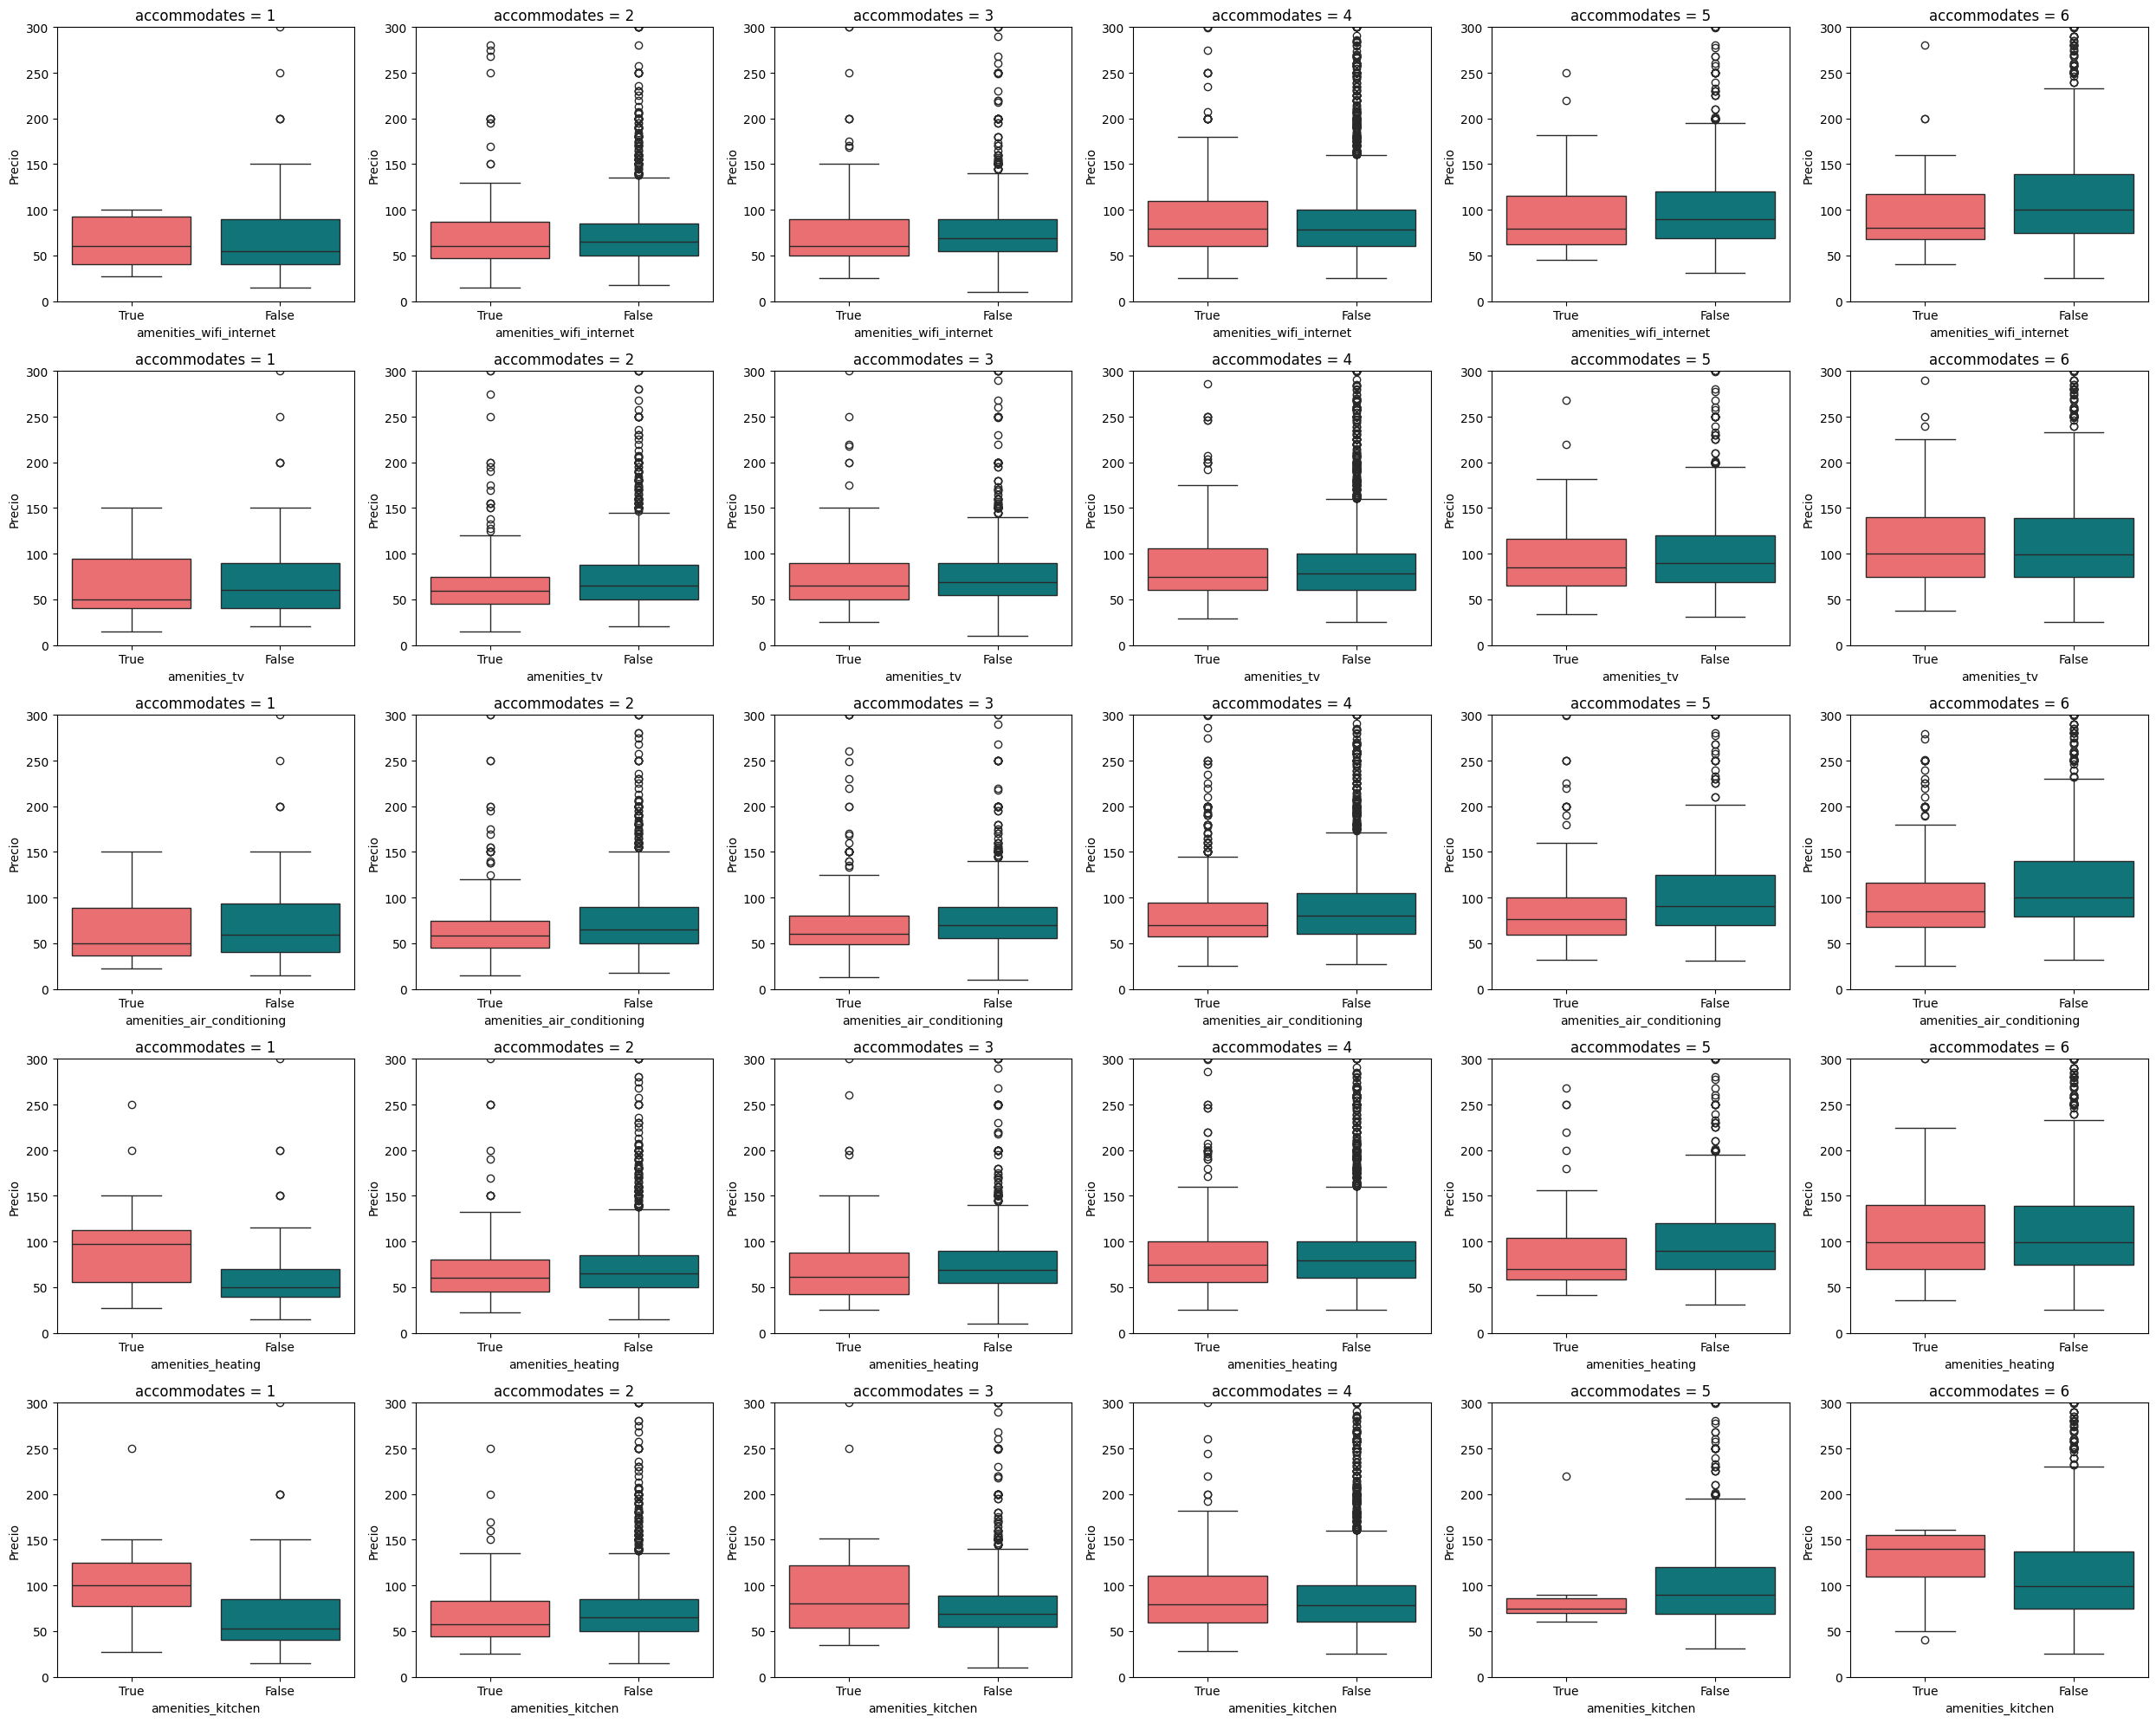

In [29]:
# GRAFICO COMPARATIVO DE BOXPLOTS PARA APARTAMENTO/CASA ENTERA SEGÚN TIENE O NO AMENITIES 
# Y SI ACOMMODATES 1,2,3,4,5 o 6 PERSONAS

# Lista de columnas amenities a considerar
amenities_columns = ['amenities_wifi_internet', 'amenities_tv', 'amenities_air_conditioning', 'amenities_heating', 'amenities_kitchen']

# Crear el gráfico de cajas
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25, 20))

# Iterar sobre cada columna de amenities
for i, column in enumerate(amenities_columns):
    for j, accommodates in enumerate([1, 2, 3, 4, 5, 6]):
        # Filtrar el dataframe por room_type == 'entire_home_apt'
        df_filtered = df_completo[(df_completo['room_type'] == 'entire_home_apt') & (df_completo['accommodates'] == accommodates) & (df_completo['price'] <= 300)]
        
        # Crear el gráfico de cajas
        sns.boxplot(data=df_filtered, x=column, y='price', palette=['#FF5A5F', '#008489'], ax=axes[i, j])
        axes[i, j].set_ylim(0, 300)
        axes[i, j].set_ylabel('Precio')
        axes[i, j].set_xlabel(column)
        axes[i, j].set_xticklabels(['True', 'False'])
        axes[i, j].set_title(f'accommodates = {accommodates}')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
print('Distribución de precios de apartamento/casa entera según comodidades, para un rango de precios de 0 a 300 euros, y según cantidad de personas')
plt.show()


<font size="6" color="#FF5A5F">CONCLUSIONES DE AMENITIES PARA PISO/CASA ENTERA (comodidades): </font>

Para piso/casa entera:  
- Tener WIFI puede aumentar el precio para piso/casa entera que acomode a 4 personas, 1 euro de mediana.
- Tener TV puede aumentar el precio para piso/casa entera que acomode a 6 personas, 1 euro de mediana.
- Tener AIRE ACONDICIONADO no aumenta el precio para piso/casa entera.
- Tener CALEFACCIÓN puede aumentar el precio para piso/casa entera que acomode a 1 persona, 47.5 euros de mediana o 6 personas, 0.5 euros de mediana.
- Tener COCINA puede aumentar el precio para piso/casa entera que acomode 1 persona, 47 euros de mediana, 3 personas, 11.5 euros de mediana, 4 personas, 1.5 euros de mediana o 6 personas, 41 euros de mediana.

-------

5. <font size="10" color="#FF5A5F">RELACIÓN DE RESEÑAS POR PRECIO. </font>

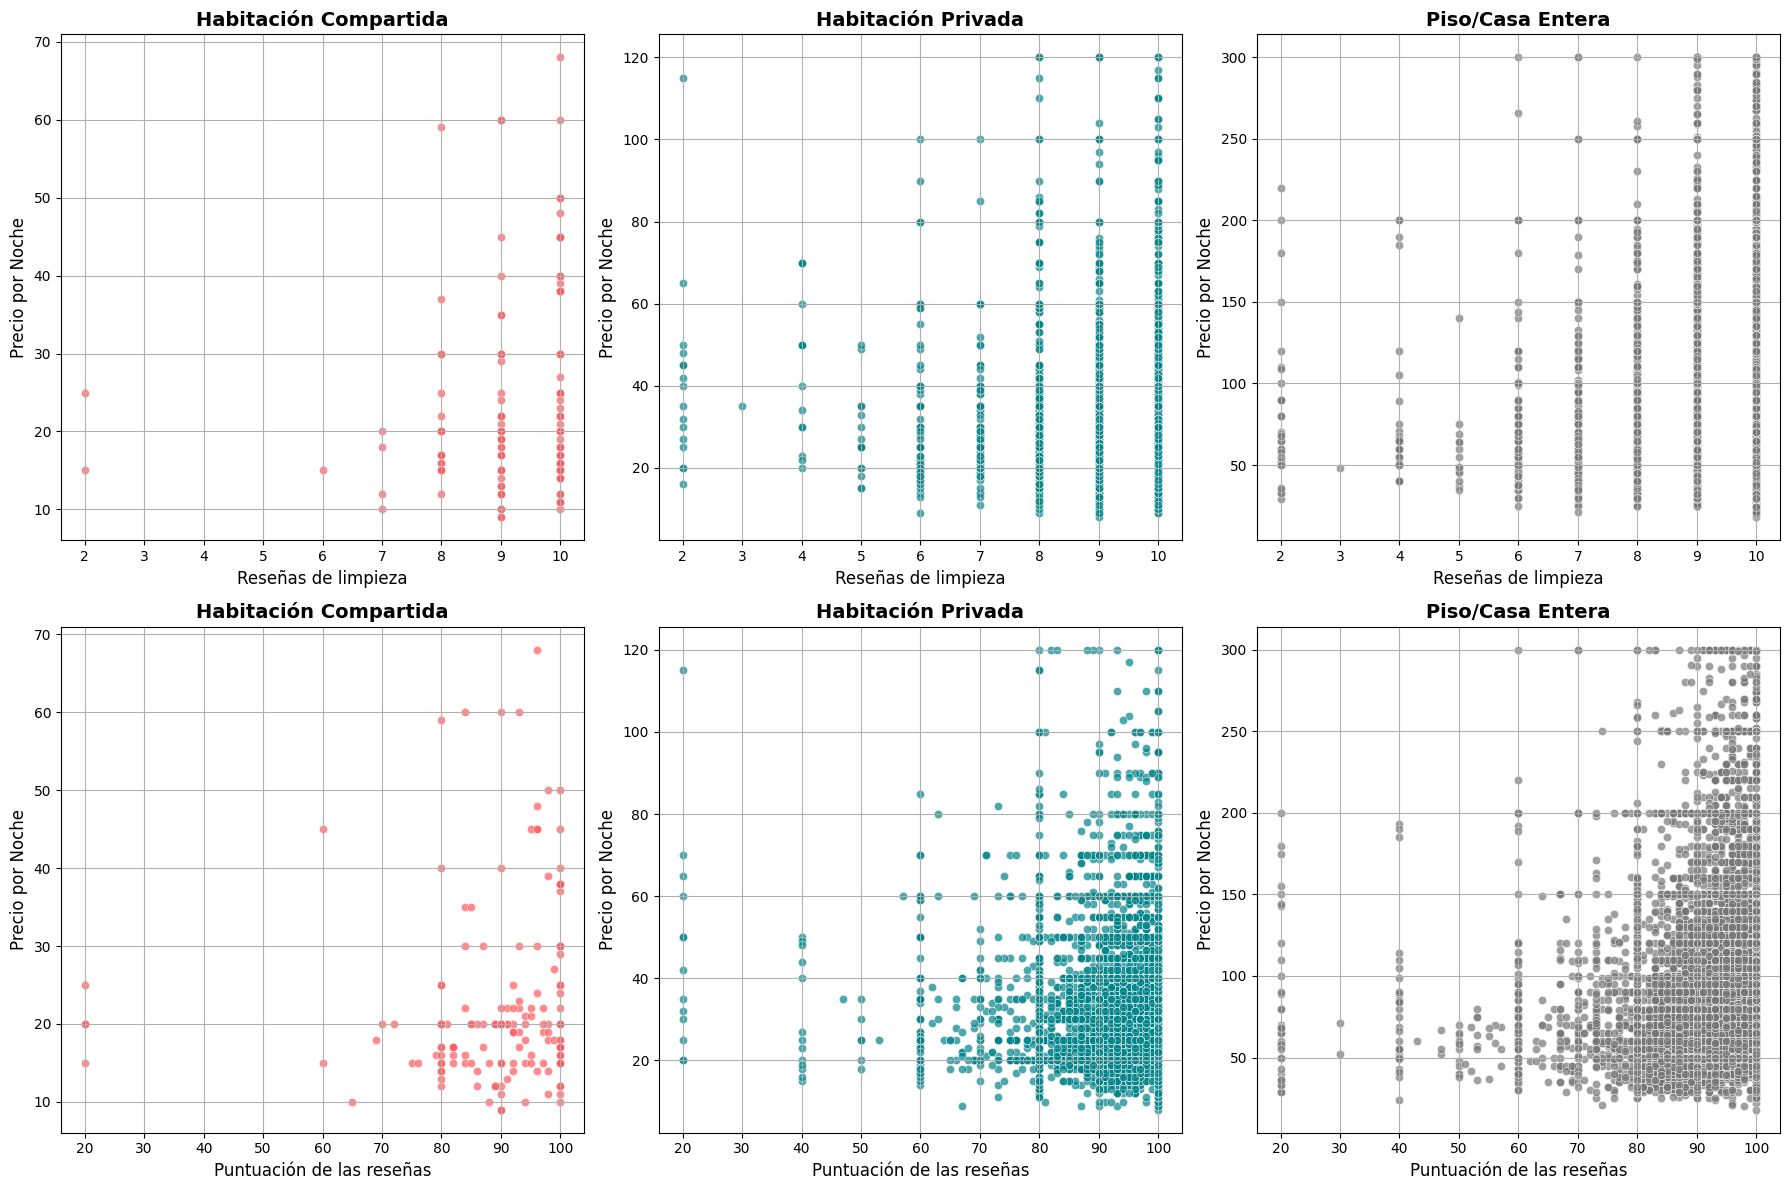

In [22]:
# GRAFICOS PARA REVIEWS SCORE Y REVIEWS POR LIMPIEZA EN RELACION AL PRECIO

# Filtrar los datos para cada tipo de habitación y rango de precio
filtered_shared_room = df_completo[(df_completo['room_type'] == 'shared_room') & (df_completo['price'] <= 70)]
filtered_private_room = df_completo[(df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120)]
filtered_entire_home_apt = df_completo[(df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300)]

# Configurar tamaño del plot
plt.figure(figsize=(18, 12))

# Gráfico de dispersión de review_scores_cleanliness vs precio por Noche
plt.subplot(2, 3, 1)
sns.scatterplot(
    data=filtered_shared_room,
    x='review_scores_cleanliness',
    y='price',
    alpha=0.7,
    color='#FF5A5F'
)
plt.title("Habitación Compartida", fontsize=14, fontweight="bold")
plt.xlabel("Reseñas de limpieza", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

plt.subplot(2, 3, 2)
sns.scatterplot(
    data=filtered_private_room,
    x='review_scores_cleanliness',
    y='price',
    alpha=0.7,
    color='#008489'
)
plt.title("Habitación Privada", fontsize=14, fontweight="bold")
plt.xlabel("Reseñas de limpieza", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

plt.subplot(2, 3, 3)
sns.scatterplot(
    data=filtered_entire_home_apt,
    x='review_scores_cleanliness',
    y='price',
    alpha=0.7,
    color='#767676'
)
plt.title("Piso/Casa Entera", fontsize=14, fontweight="bold")
plt.xlabel("Reseñas de limpieza", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

# Gráfico de dispersión de review_scores_rating vs precio por Noche
plt.subplot(2, 3, 4)
sns.scatterplot(
    data=filtered_shared_room,
    x='review_scores_rating',
    y='price',
    alpha=0.7,
    color='#FF5A5F'
)
plt.title("Habitación Compartida", fontsize=14, fontweight="bold")
plt.xlabel("Puntuación de las reseñas", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

plt.subplot(2, 3, 5)
sns.scatterplot(
    data=filtered_private_room,
    x='review_scores_rating',
    y='price',
    alpha=0.7,
    color='#008489'
)
plt.title("Habitación Privada", fontsize=14, fontweight="bold")
plt.xlabel("Puntuación de las reseñas", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

plt.subplot(2, 3, 6)
sns.scatterplot(
    data=filtered_entire_home_apt,
    x='review_scores_rating',
    y='price',
    alpha=0.7,
    color='#767676'
)
plt.title("Piso/Casa Entera", fontsize=14, fontweight="bold")
plt.xlabel("Puntuación de las reseñas", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

# Ajustar diseño
plt.tight_layout()

# Mostrar los gráficos
plt.show()


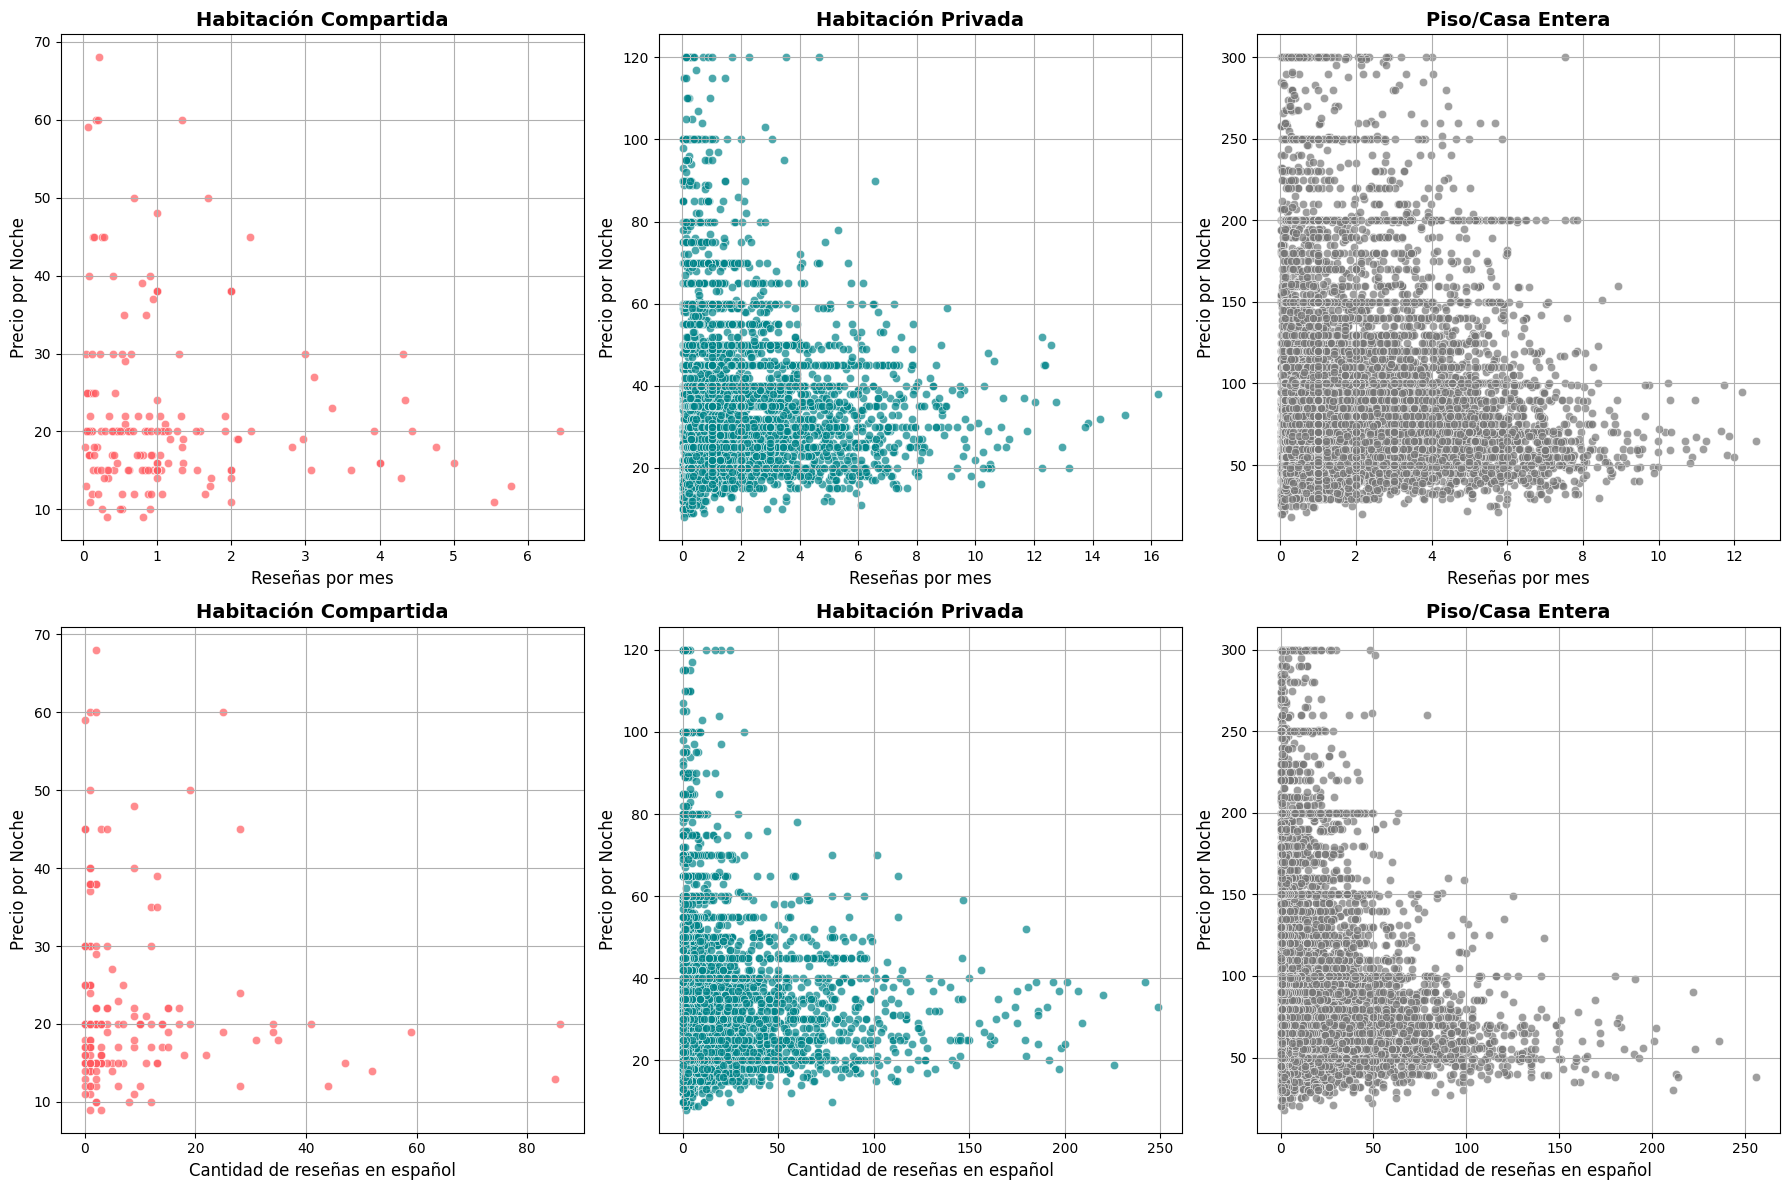

In [23]:
# GRAFICOS PARA REVIEWS POR MES Y CANTIDAD TOTAL DE REVIEWS EN RELACION AL PRECIO

# Filtrar los datos para cada tipo de habitación y rango de precio
filtered_shared_room = df_completo[(df_completo['room_type'] == 'shared_room') & (df_completo['price'] <= 70)]
filtered_private_room = df_completo[(df_completo['room_type'] == 'private_room') & (df_completo['price'] <= 120)]
filtered_entire_home_apt = df_completo[(df_completo['room_type'] == 'entire_home_apt') & (df_completo['price'] <= 300)]

# Configurar tamaño del plot
plt.figure(figsize=(18, 12))

# Gráfico de dispersión de reviews_per_month vs precio por Noche
plt.subplot(2, 3, 1)
sns.scatterplot(
    data=filtered_shared_room,
    x='reviews_per_month',
    y='price',
    alpha=0.7,
    color='#FF5A5F'
)
plt.title("Habitación Compartida", fontsize=14, fontweight="bold")
plt.xlabel("Reseñas por mes", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

plt.subplot(2, 3, 2)
sns.scatterplot(
    data=filtered_private_room,
    x='reviews_per_month',
    y='price',
    alpha=0.7,
    color='#008489'
)
plt.title("Habitación Privada", fontsize=14, fontweight="bold")
plt.xlabel("Reseñas por mes", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

plt.subplot(2, 3, 3)
sns.scatterplot(
    data=filtered_entire_home_apt,
    x='reviews_per_month',
    y='price',
    alpha=0.7,
    color='#767676'
)
plt.title("Piso/Casa Entera", fontsize=14, fontweight="bold")
plt.xlabel("Reseñas por mes", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

# Gráfico de dispersión de number_of_reviews_es vs precio por Noche
plt.subplot(2, 3, 4)
sns.scatterplot(
    data=filtered_shared_room,
    x='number_of_reviews_es',
    y='price',
    alpha=0.7,
    color='#FF5A5F'
)
plt.title("Habitación Compartida", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de reseñas en español", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

plt.subplot(2, 3, 5)
sns.scatterplot(
    data=filtered_private_room,
    x='number_of_reviews_es',
    y='price',
    alpha=0.7,
    color='#008489'
)
plt.title("Habitación Privada", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de reseñas en español", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

plt.subplot(2, 3, 6)
sns.scatterplot(
    data=filtered_entire_home_apt,
    x='number_of_reviews_es',
    y='price',
    alpha=0.7,
    color='#767676'
)
plt.title("Piso/Casa Entera", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de reseñas en español", fontsize=12)
plt.ylabel("Precio por Noche", fontsize=12)
plt.grid(True)

# Ajustar diseño
plt.tight_layout()

# Mostrar los gráficos
plt.show()


<font size="6" color="#FF5A5F">CONCLUSIONES DE REVIEWS </font>


Los alojamientos con la mayor cantidad de excelentes reseñas sobre la limpieza podrían justificar precios más elevados dentro de su categoría.  
Por otro lado, una abundancia de críticas positivas en cuanto a la calificación general (review_score_rating), especialmente en el caso de habitaciones privadas y alojamientos enteros, parece no estar relacionada con precios más altos, aunque es de mencionar, que los precios más altos no poseen menos críticas negativas.

En relación a la cantidad de reseñas mensuales o la cantidad de reseñas total, se sugiere que menos reseñas podrían ser indicativas de una mejor percepción y la posibilidad de aumentar el precio.

--------

6. <font size="10" color="#FF5A5F">RELACIÓN DE ANFITRIÓN POR PRECIO. </font>

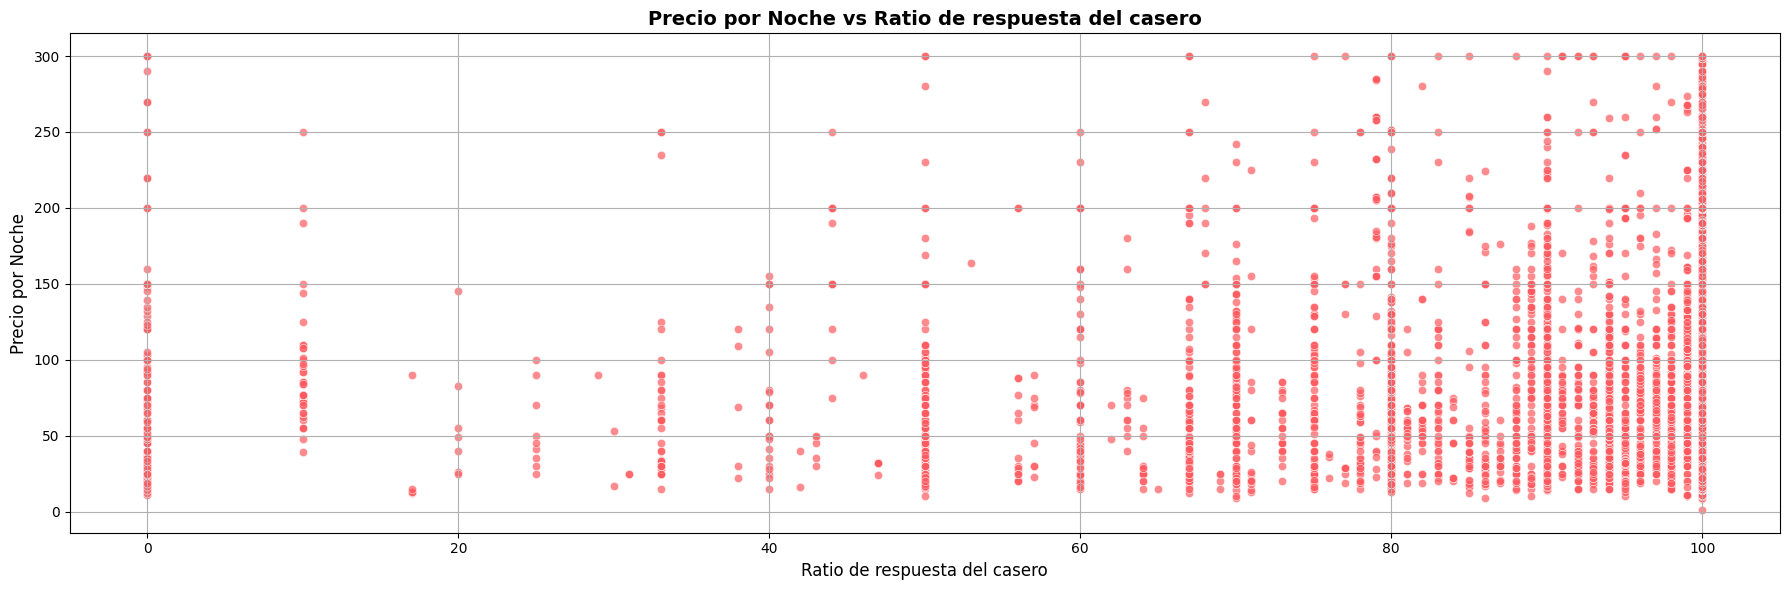

In [24]:
# GRAFICO SCATTER PLOT DE HOST_RESPONSE_RATE

# Variables para generar scatter plot de host_response_rate
variables = ['host_response_rate']

# Configurar tamaño del plot
plt.figure(figsize=(18, 6))

# Filtrar los datos para el rango de precio de 0 a 300
filtered_data = df_completo[df_completo['price'] <= 300]

# Generar scatter plots para cada variable
for i, var in enumerate(variables, 1):
    plt.subplot(1, 1, i)
    sns.scatterplot(
        data=filtered_data,
        x=var,
        y='price',
        alpha=0.7,
        color='#FF5A5F'
    )
    plt.title(f"Precio por Noche vs Ratio de respuesta del casero", fontsize=14, fontweight="bold")
    plt.xlabel("Ratio de respuesta del casero", fontsize=12)
    plt.ylabel("Precio por Noche", fontsize=12)
    plt.grid(True)

# Ajustar diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3810971897.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3810971897.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3810971897.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3810971897.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3810971897.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3810971897.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3810971897.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/ltdjzyrn0xd30drnlh6f8z2h0000gn/T/ipykernel_45906/3810971897.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

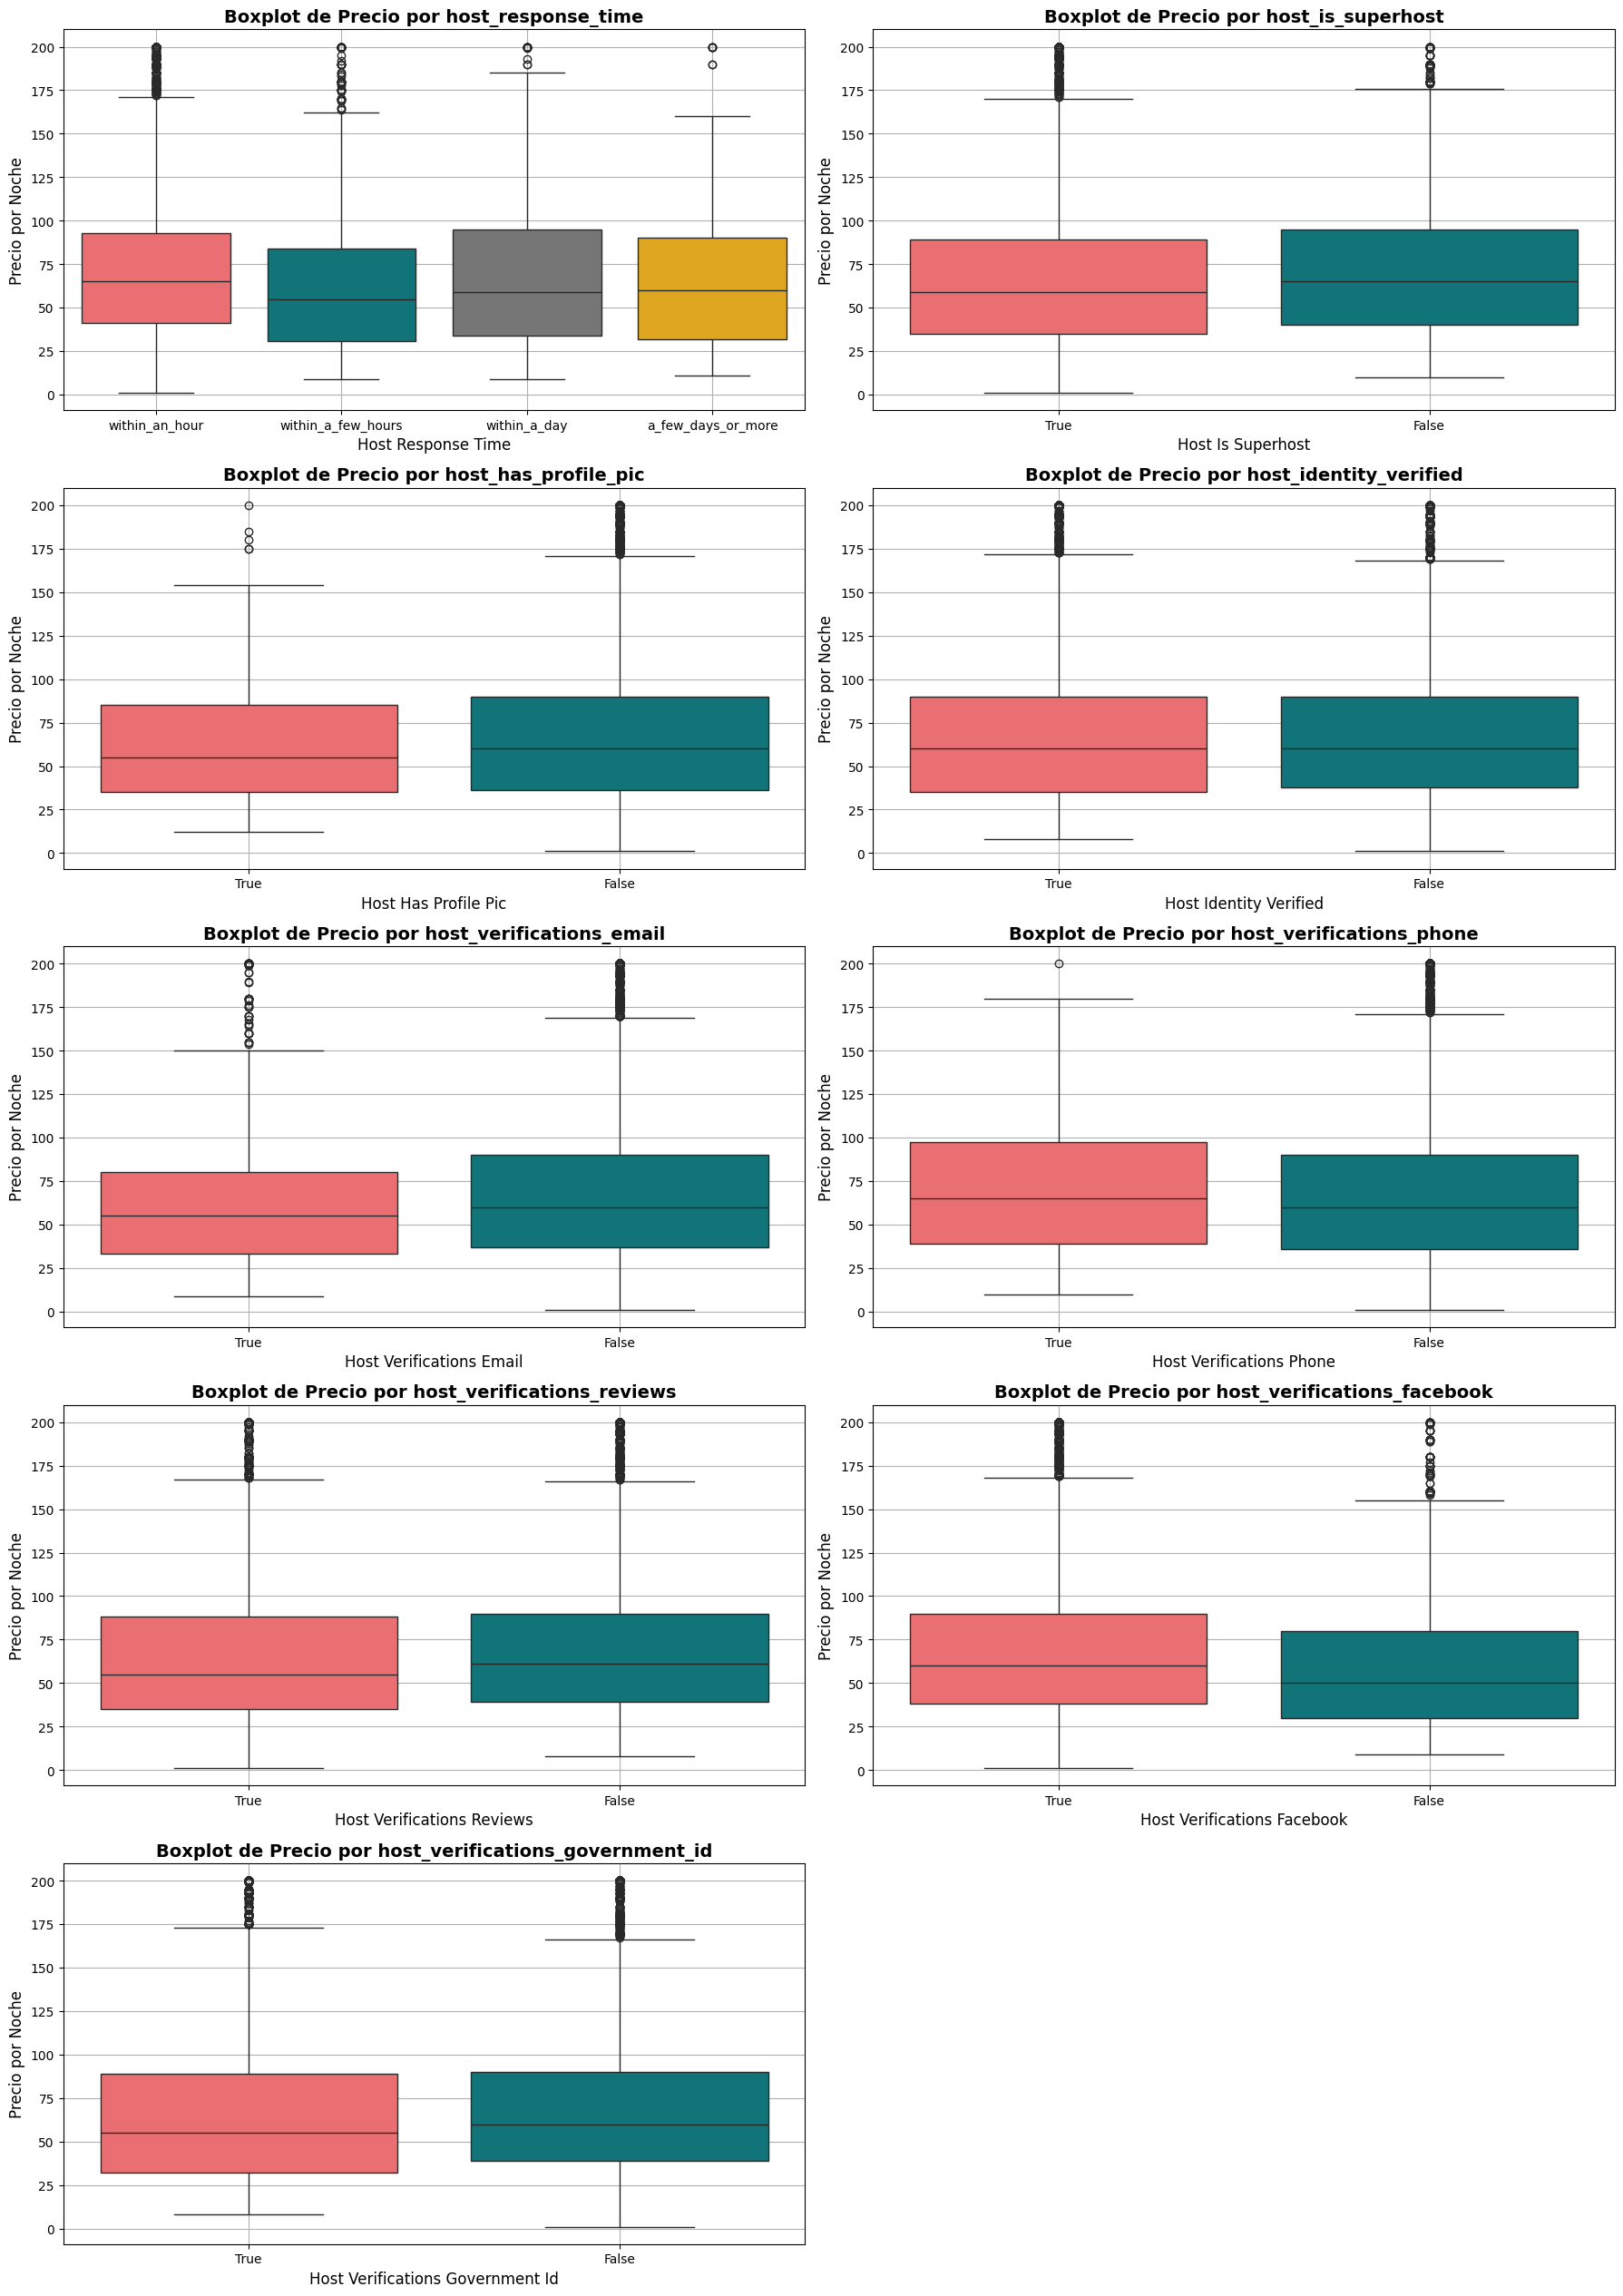

In [25]:
# BOXPLOTS DE HOST VS PRICE

# Variables para generar boxplots
variables = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 
             'host_identity_verified', 'host_verifications_email', 
             'host_verifications_phone', 'host_verifications_reviews', 
             'host_verifications_facebook', 
             'host_verifications_government_id']

# Configurar tamaño del plot
plt.figure(figsize=(18, 30))

# Filtrar los datos para el rango de precio de 0 a 200
filtered_data = df_completo[df_completo['price'] <= 200]

# Generar boxplots para cada variable
for i, var in enumerate(variables, 1):
    plt.subplot(6, 2, i)
    if var == 'host_response_time':
        sns.boxplot(
            x=var,
            y='price',
            data=filtered_data[filtered_data[var] != 'None'], # Descartar valores 'None'
            palette=["#FF5A5F", "#008489", "#767676", "#FFB400"] # Colores especificados
        )
    else:
        sns.boxplot(
            x=var,
            y='price',
            data=filtered_data,
            palette=["#FF5A5F", "#008489"]
        )
        # Cambiar etiquetas de los ticks en el eje x
        plt.xticks([0, 1], ['True', 'False'])
    
    plt.title(f"Boxplot de Precio por {var}", fontsize=14, fontweight="bold")
    plt.xlabel(var.replace('_', ' ').title(), fontsize=12)
    plt.ylabel("Precio por Noche", fontsize=12)
    plt.grid(True)

# Ajustar diseño
plt.tight_layout()

# Mostrar los gráficos
plt.show()



<font size="6" color="#FF5A5F">CONCLUSIONES DE ANFITRIÓN </font>

La tasa de respuesta del anfitrión, especialmente dentro del primer día, aumenta la posibilidad de que los precios de los alquileres sean más altos.  
Ser superhost, tener una foto de perfil y verificar el correo electrónico o la identificación (DNI) no parecen tener un impacto significativo en el precio de los alquileres, aunque podrían ser considerados como exigencia en propiedades más caras.  
Por otro lado, la verificación del número de teléfono y la cuenta de Facebook parece estar asociada a un aumento en el precio de los alquileres.